# Speech Command Recognition

This notebook presents an attention model for speech command recognotion. We use Google Speech Commands Dataset to test the Keras generator for sound files and the proposed RNN attention model.


## Download files and load information

Dynamically load speech data from the disk to allow handling big datasets.

First step: download Google Speech Command Dataset and convert all WAV files to numpy arrays for faster load (about 10x faster than loading raw WAV).

In [2]:
%pip install librosa -q

In [3]:

useColab=True
if useColab:
    # Use tensorflow 2.10 or 2.11
    !wget -q https://raw.githubusercontent.com/Ashraf2016/ImgDetect/refs/heads/master/SpeechDownloader.py
    !wget -q https://raw.githubusercontent.com/Ashraf2016/ImgDetect/refs/heads/master/SpeechGenerator.py
    !wget -q https://raw.githubusercontent.com/Ashraf2016/ImgDetect/refs/heads/master/audioUtils.py
    !wget -q https://raw.githubusercontent.com/Ashraf2016/ImgDetect/refs/heads/master/SpeechModels.py
    !wget -q https://raw.githubusercontent.com/Ashraf2016/ImgDetect/refs/heads/master/requirements.txt
    #!pip install -r requirements.txt
    !pip install tensorflow==2.19.0
    !pip install pandas>=0.25 tqdm librosa matplotlib


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 644.9/644.9 MB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.7/4.7 MB 98.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 107.4 MB/s eta 0:00:00
  Attempting uninstall: ml-dtypes
    Found existing installation: ml-dtypes 0.4.1
    Uninstalling ml-dtypes-0.4.1:
      Successfully uninstalled ml-dtypes-0.4.1
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.18.0
    Uninstalling tensorboard-2.18.0:
      Successfully uninstalled tensorboard-2.18.0
  Attempting uninstall: tensorflow
    Found existing installation: tensorflow 2.18.0
    Uninstalling tensorflow-2.18.0:
      Successfully uninstalled tensorflow-2.18.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tf-keras 2.18.0 requires tensorflow<2.19,>=2.18, but you have tensorflow 2.19.0 

In [4]:
# import os
# os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

import tensorflow as tf
tf.config.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [5]:
%load_ext autoreload
%autoreload 2

import matplotlib
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import SpeechDownloader
import SpeechGenerator
import SpeechModels
import audioUtils

In [6]:
inp = tf.zeros( (2, 16000), dtype=tf.float32)
inp.shape
# audioUtils.normalized_mel_spectrogram( )

TensorShape([2, 16000])

In [7]:
inp * 3

<tf.Tensor: shape=(2, 16000), dtype=float32, numpy=
array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)>

In [8]:
stft = tf.signal.stft(
    inp,
    frame_length=1024,
    frame_step=128,
    window_fn=tf.signal.hann_window,
    pad_end=True,
)
stft.shape

TensorShape([2, 125, 513])

In [9]:
# Download and prepare all data
gscInfo, nCategs = SpeechDownloader.PrepareGoogleSpeechCmd(version=2, task='35word')

110kKB [00:01, 97.0kKB/s]                          


2.37MKB [00:39, 60.8kKB/s]                          


Extracting sd_GSCmdV2/test.tar.gz into sd_GSCmdV2/test/
Extracting sd_GSCmdV2/train.tar.gz into sd_GSCmdV2/train/
Converting test set WAVs to numpy files


100%|██████████| 4890/4890 [00:04<00:00, 1111.39it/s]


Converting training set WAVs to numpy files


100%|██████████| 105835/105835 [02:31<00:00, 696.70it/s]


Done preparing Google Speech commands dataset version 2


We should have 4 datasets, each with file names 'files' and their categories 'labels' in a dict.

In [10]:
print(gscInfo.keys())
print(gscInfo['train'].keys())
print(len(gscInfo['train']['files']))
print(nCategs)

dict_keys(['train', 'test', 'val', 'testREAL'])
dict_keys(['files', 'labels'])
84849
36


# Speech Data Generator

Use Keras to create a generator that reads files on the fly.

In [11]:
sr = 16000 #we know this one for google audios
iLen = 16000
trainGen = SpeechGenerator.SpeechGen(gscInfo['train']['files'], gscInfo['train']['labels'], shuffle=True)
# handle the fact that number of samples in validation may not be multiple of batch_size with shuffle=True
valGen   = SpeechGenerator.SpeechGen(gscInfo['val']['files'], gscInfo['val']['labels'], shuffle=True)

# use batch_size = total number of files to read all test files at once
testGen  = SpeechGenerator.SpeechGen(gscInfo['test']['files'], gscInfo['test']['labels'], shuffle=False, batch_size=len(gscInfo['test']['files']))
testRGen = SpeechGenerator.SpeechGen(gscInfo['testREAL']['files'], gscInfo['testREAL']['labels'], shuffle=False, batch_size=len(gscInfo['testREAL']['files']))
valGen.__len__()

311

In [12]:
audios, classes = valGen.__getitem__(5)
classes

array([ 8,  1, 23, 13,  1,  7, 19, 23, 34, 16, 12, 18, 20, 17, 29,  7, 16,
       35, 17, 31, 18, 22, 19, 27,  9,  5, 19, 19,  5, 14,  2,  7])

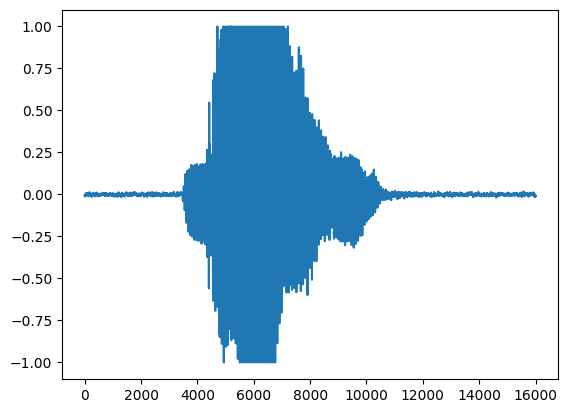

In [13]:
# librosa.output.write_wav('file.wav', audios[4], sr, norm=False)
plt.plot(audios[4])

In [14]:
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers as L
from tensorflow.keras import Model
from tensorflow.keras import layers

class NormalizedMelSpectrogramLayer(layers.Layer):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)

    def call(self, inputs):
        return audioUtils.normalized_mel_spectrogram(inputs)


inp = L.Input((iLen,), name='input')
mel_spec = NormalizedMelSpectrogramLayer()(inp)
melspecModel = Model(inputs=inp, outputs=mel_spec, name='normalized_spectrogram_model')

melspecModel.summary()

Model: "normalized_spectrogram_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input (InputLayer)              │ (None, 16000)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ normalized_mel_spectrogram_lay… │ (None, 125, 80)        │             0 │
│ (NormalizedMelSpectrogramLayer) │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [15]:
audios.shape

(32, 16000)

In [16]:
melspec = melspecModel.predict(audios)
melspec.shape

np.min(melspec[9,:,:].T), np.max(melspec[9,:,:].T), np.mean(melspec[9,:,:].T)

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


(np.float32(-1.9551332), np.float32(2.2734523), np.float32(0.06216994))

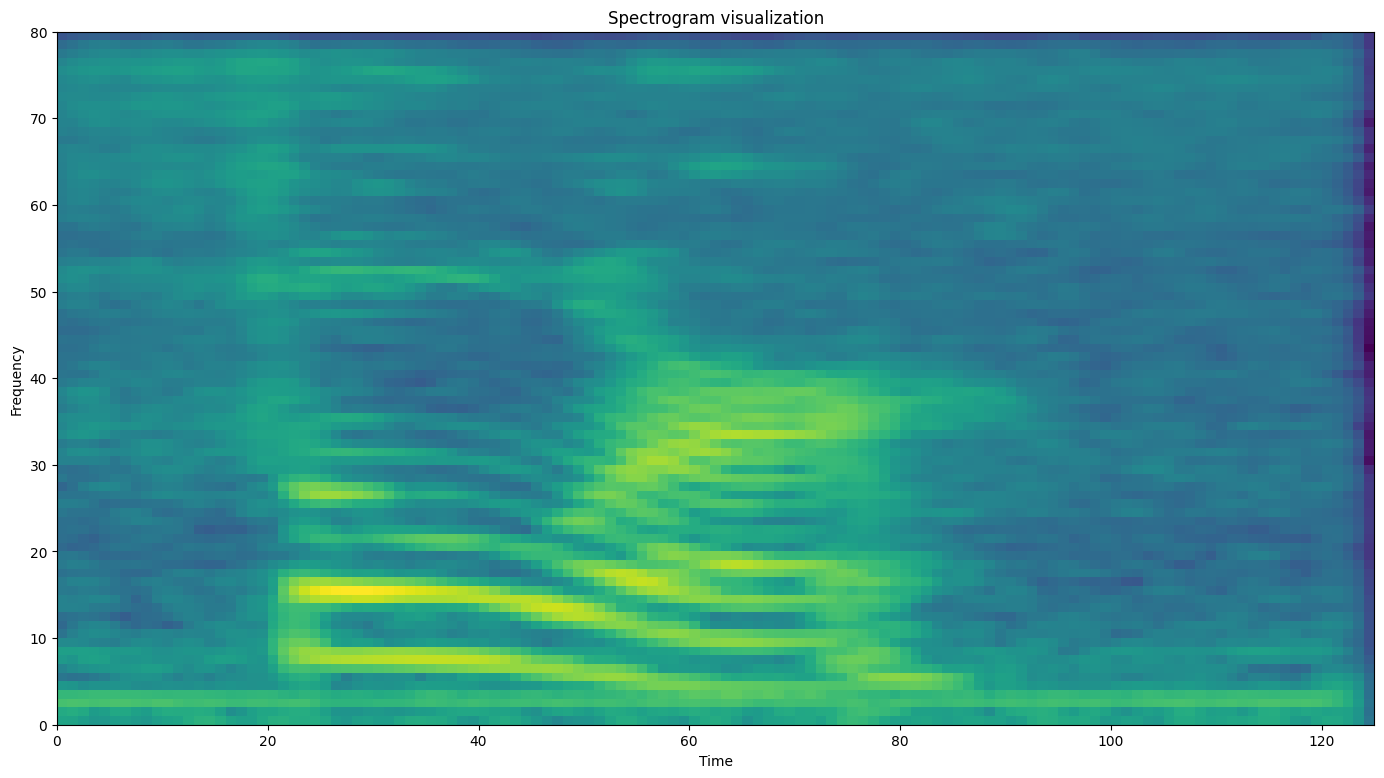

In [17]:
plt.figure(figsize=(17,9))
plt.pcolormesh(melspec[9,:,:].T)

plt.title('Spectrogram visualization')
plt.ylabel('Frequency')
plt.xlabel('Time')

plt.show()

In [18]:
import librosa

# Check if mel spectrogram matches the one computed with librosa
librosa_melspec = librosa.feature.melspectrogram(y=audios[9], sr=sr, n_fft=1024,
                                                 hop_length=128, power=1.0, #window='hann',
                                                 n_mels=80, fmin=40.0, fmax=sr/2)
S_dB = librosa.power_to_db(librosa_melspec, ref=np.max)
np.min(S_dB), np.max(S_dB)

(np.float64(-45.68033631150152), np.float64(0.0))

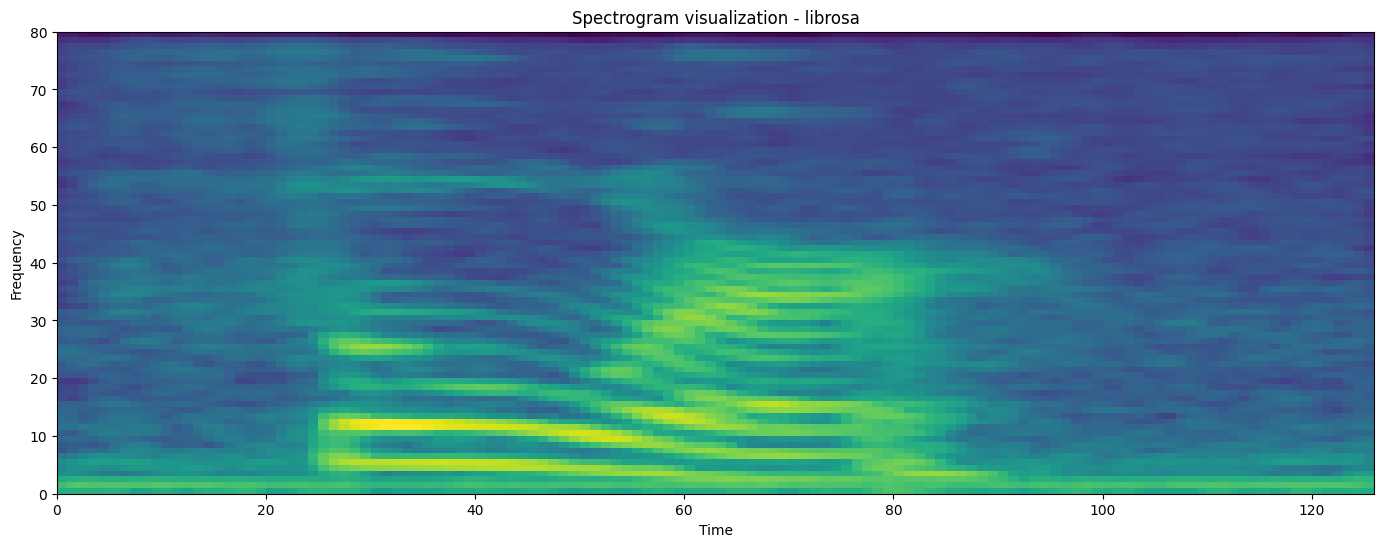

In [19]:
plt.figure(figsize=(17,6))
plt.pcolormesh(S_dB)

plt.title('Spectrogram visualization - librosa')
plt.ylabel('Frequency')
plt.xlabel('Time')

plt.show()

In [20]:
# plt.hist(melspec.flatten(), bins=100)

# Models

Create Keras models to see if the generators are working properly

In [21]:
from tensorflow.keras.models import Model, load_model

In [22]:
model = SpeechModels.AttRNNSpeechModel(nCategs, samplingrate = sr, inputLength = None)#, rnn_func=L.LSTM)

model.compile(optimizer='adam', loss=['sparse_categorical_crossentropy'], metrics=['sparse_categorical_accuracy'])
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input (InputLayer)  │ (None, None)      │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalized_spectro… │ (None, None, 80)  │          0 │ input[0][0]       │
│ (Functional)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ mel_stft (Lambda)   │ (None, None, 80,  │          0 │ normalized_spect… │
│                     │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, None, 80,  │         60 │ mel_stft[0][0]    │
│                     │ 10)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, None, 80,  │         40 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 10)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, None, 80,  │         51 │ batch_normalizat… │
│                     │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, None, 80,  │          4 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ squeeze_last_dim    │ (None, None, 80)  │          0 │ batch_normalizat… │
│ (Lambda)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional       │ (None, None, 128) │     74,240 │ squeeze_last_dim… │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_1     │ (None, None, 128) │     98,816 │ bidirectional[0]… │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda (Lambda)     │ (None, 128)       │          0 │ bidirectional_1[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 128)       │     16,512 │ lambda[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dot (Dot)           │ (None, None)      │          0 │ dense[0][0],      │
│                     │                   │            │ bidirectional_1[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ attSoftmax          │ (None, None)      │          0 │ dot[0][0]         │
│ (Softmax)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dot_1 (Dot)         │ (None, 128)       │          0 │ attSoftmax[0][0], │
│                     │                   │            │ bidirectional_1[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 64)        │      8,256 │ dot_1[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 32)        │      2,080 │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ output (Dense)      │ (None, 36)        │      1,188 │ dense_2[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 201,247 (786.12 KB)

 Trainable params: 201,225 (786.04 KB)

 Non-trainable params: 22 (88.00 B)

In [23]:
# model.load_weights('model-attRNN.h5')

In [24]:
import math
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, LearningRateScheduler
def step_decay(epoch):
    initial_lrate = 0.001
    drop = 0.4
    epochs_drop = 15.0
    lrate = initial_lrate * math.pow(drop,
            math.floor((1+epoch)/epochs_drop))

    if (lrate < 4e-5):
        lrate = 4e-5

    print('Changing learning rate to {}'.format(lrate))
    return lrate
lrate = LearningRateScheduler(step_decay)

In [27]:
earlystopper = EarlyStopping(monitor='val_sparse_categorical_accuracy', patience=10,
                             verbose=1, restore_best_weights=True)
checkpointer = ModelCheckpoint('model-attRNN.h5', monitor='val_sparse_categorical_accuracy',
                               verbose=1, save_best_only=True)

results = model.fit(trainGen,
                    validation_data=valGen,
                    epochs=2,
                    verbose=1,
                    callbacks=[earlystopper, checkpointer, lrate])

model.save('model-attRNN.keras')


Changing learning rate to 0.001
Epoch 1/2
2650/2651 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - loss: 0.2394 - sparse_categorical_accuracy: 0.9276
Epoch 1: val_sparse_categorical_accuracy improved from -inf to 0.92816, saving model to model-attRNN.h5


2651/2651 ━━━━━━━━━━━━━━━━━━━━ 125s 47ms/step - loss: 0.2394 - sparse_categorical_accuracy: 0.9276 - val_loss: 0.2530 - val_sparse_categorical_accuracy: 0.9282 - learning_rate: 0.0010
Changing learning rate to 0.001
Epoch 2/2
2650/2651 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 0.1935 - sparse_categorical_accuracy: 0.9399
Epoch 2: val_sparse_categorical_accuracy improved from 0.92816 to 0.93047, saving model to model-attRNN.h5


2651/2651 ━━━━━━━━━━━━━━━━━━━━ 141s 47ms/step - loss: 0.1935 - sparse_categorical_accuracy: 0.9399 - val_loss: 0.2400 - val_sparse_categorical_accuracy: 0.9305 - learning_rate: 0.0010
Restoring model weights from the end of the best epoch: 2.


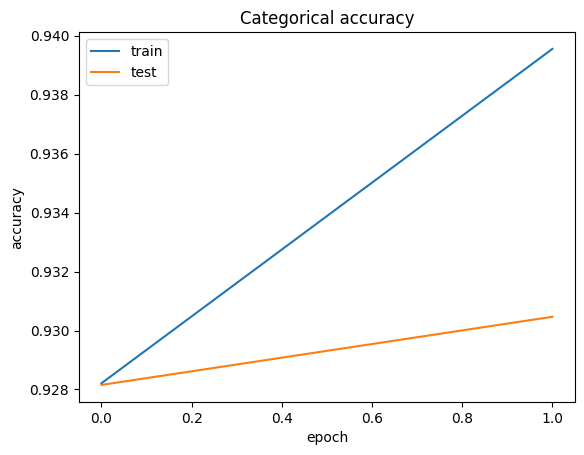

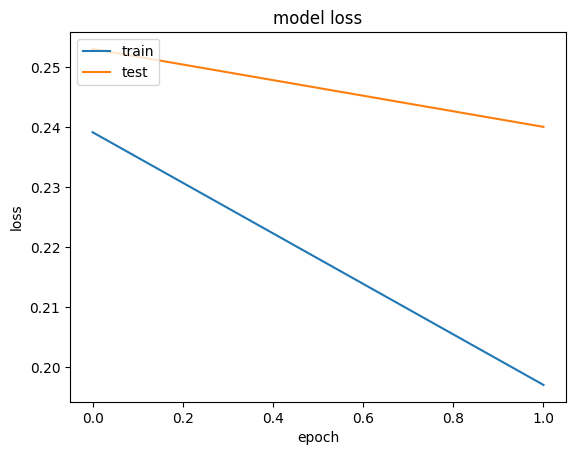

In [28]:
# summarize history for categorical accuracy
plt.plot(results.history['sparse_categorical_accuracy'])
plt.plot(results.history['val_sparse_categorical_accuracy'])
plt.title('Categorical accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(results.history['loss'])
plt.plot(results.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [29]:
# results.history

In [30]:
# load best model according to cross-validation - model-attRNN
# model = load_model('model-attRNN.h5', custom_objects={'Melspectrogram': Melspectrogram, 'Normalization2D': Normalization2D })
model.load_weights('model-attRNN.h5')

In [31]:
# tf.saved_model.save(model, 'model-KWS-attRNN')

In [33]:
#read all test data
x_test, y_test = testGen.__getitem__(0)

In [34]:
valEval = model.evaluate(valGen, verbose=0)
trainEval = model.evaluate(trainGen, verbose=0)
testEval = model.evaluate(x_test, y_test, verbose=0)

print('Evaluation scores: \nMetrics: {} \nTrain: {} \nValidation: {} \nTest: {}'.format(model.metrics_names, trainEval, valEval, testEval))

Evaluation scores: 
Metrics: ['loss', 'compile_metrics'] 
Train: [0.1684773564338684, 0.9482035040855408] 
Validation: [0.2400839775800705, 0.9308681488037109] 
Test: [0.24978645145893097, 0.9231258630752563]


In [35]:
kaggle12cmd = False
if kaggle12cmd:
    #only for the Kaggle competition, 12-cmd
    x_testR, y_testR = testRGen.__getitem__(0)
    testREval = model.evaluate(x_testR, y_testR, verbose=1)
    print(testREval)
    testREval = model.evaluate(testRGen, use_multiprocessing=True, workers=4,verbose=1)
    print(testREval)

## Evaluation and Attention Plots

In [38]:
attSpeechModel = Model(inputs=model.input,
                       outputs=[model.get_layer('output').output,
                                model.get_layer('attSoftmax').output,
                                model.get_layer('mel_stft').output])


In [39]:
audios, classes = valGen.__getitem__(3)
classes

array([ 6, 32, 15, 14, 22,  4,  9, 19, 24, 14, 10,  6,  7, 10, 18, 20, 29,
        9,  8, 18, 27, 16, 35,  3, 10, 30, 35, 12, 14, 15,  6, 31])

In [40]:
#8 - on, 13 - one, 7 - right
idAudio = 8
classes[idAudio]

np.int64(24)

In [41]:
outs, attW, specs = attSpeechModel.predict(audios)

/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['input']
Received: inputs=Tensor(shape=(32, 16000))
  warnings.warn(msg)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 782ms/step


In [42]:
np.argmax(outs,axis=1)

array([ 6, 32, 15, 11, 22,  4,  4, 19, 24, 14, 10,  6,  7, 10, 18, 20, 29,
        9,  8, 18, 27, 16, 35,  3, 10, 30, 35, 12, 14, 15,  6, 31])

In [43]:
specs.shape

(32, 125, 80, 1)

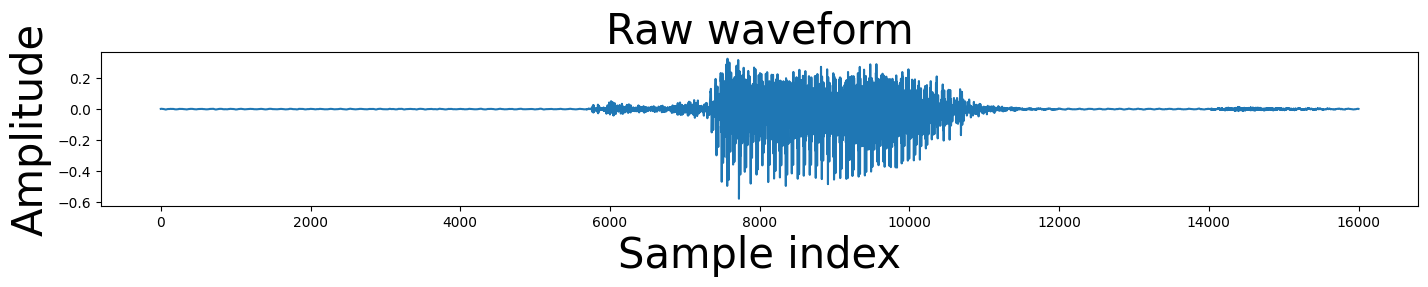

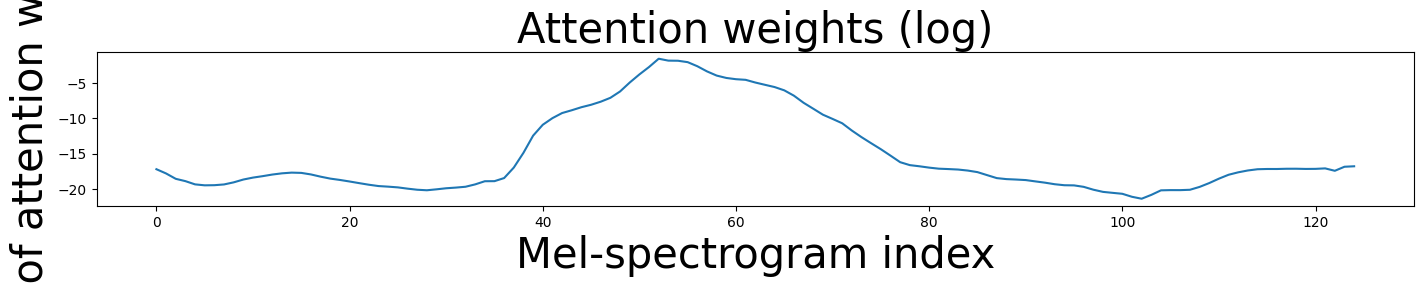

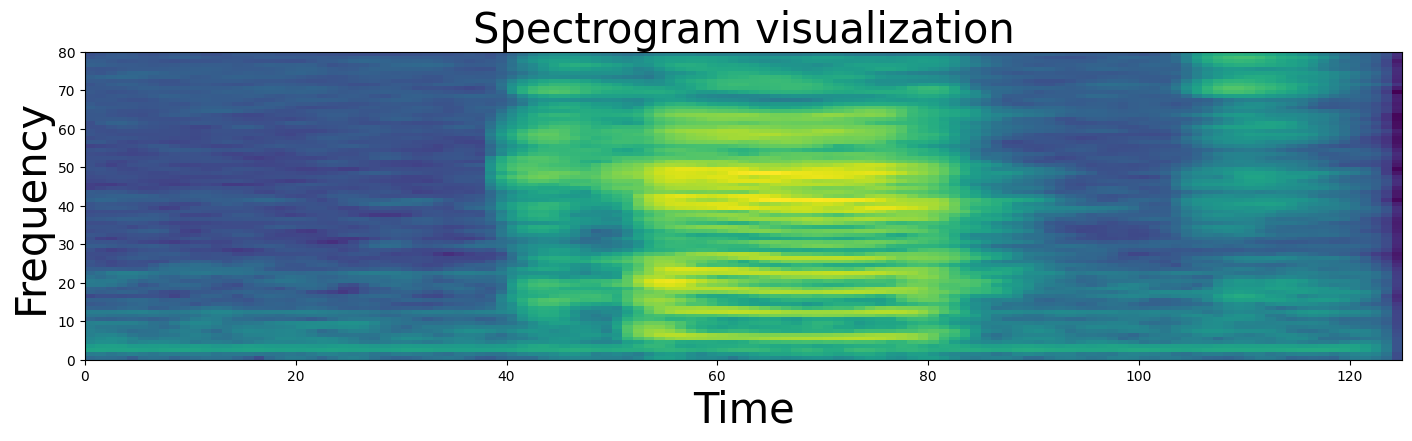

In [44]:
imgHeight = 2

plt.figure(figsize=(17,imgHeight))
plt.title('Raw waveform', fontsize=30)
plt.ylabel('Amplitude', fontsize=30)
plt.xlabel('Sample index', fontsize=30)
plt.plot(audios[idAudio])
plt.savefig('picrawWave.png', dpi = 400)
plt.show()

plt.figure(figsize=(17,imgHeight))
plt.title('Attention weights (log)', fontsize=30)
plt.ylabel('Log of attention weight', fontsize=30)
plt.xlabel('Mel-spectrogram index', fontsize=30)
plt.plot(np.log(attW[idAudio]))
plt.savefig('picAttention.png', dpi = 400)
plt.show()


plt.figure(figsize=(17,imgHeight*2))
plt.pcolormesh(specs[idAudio,:,:,0].T)

plt.title('Spectrogram visualization', fontsize=30)
plt.ylabel('Frequency', fontsize=30)
plt.xlabel('Time', fontsize=30)
plt.savefig('picmelSpec.png', dpi = 400)

plt.show()

In [45]:
y_pred = model.predict(x_test, verbose=1)

344/344 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step


In [46]:
from sklearn.metrics import confusion_matrix
import audioUtils
cm = confusion_matrix(y_test, np.argmax(y_pred,1))

In [47]:
#set(y_test)

In [48]:
#35word, v2
classes = ['nine', 'yes', 'no', 'up', 'down', 'left', 'right', 'on', 'off', 'stop', 'go',
           'zero', 'one', 'two', 'three', 'four', 'five', 'six',
           'seven',  'eight', 'backward', 'bed', 'bird', 'cat', 'dog',
           'follow', 'forward', 'happy', 'house', 'learn', 'marvin', 'sheila', 'tree',
           'visual', 'wow']

In [49]:
#35word, v1
#classes=['nine', 'yes',  'no', 'up', 'down', 'left', 'right', 'on', 'off', 'stop', 'go',
#         'zero', 'one', 'two', 'three', 'four', 'five', 'six', 'seven',  'eight',
#         'bed', 'bird', 'cat', 'dog', 'happy', 'house',
#         'marvin', 'sheila', 'tree', 'wow']

In [50]:
#20cmd
#classes=['unknown', 'nine', 'yes',  'no', 'up', 'down', 'left', 'right', 'on', 'off', 'stop', 'go',
#         'zero', 'one', 'two', 'three', 'four', 'five', 'six', 'seven',  'eight']

Confusion matrix, without normalization


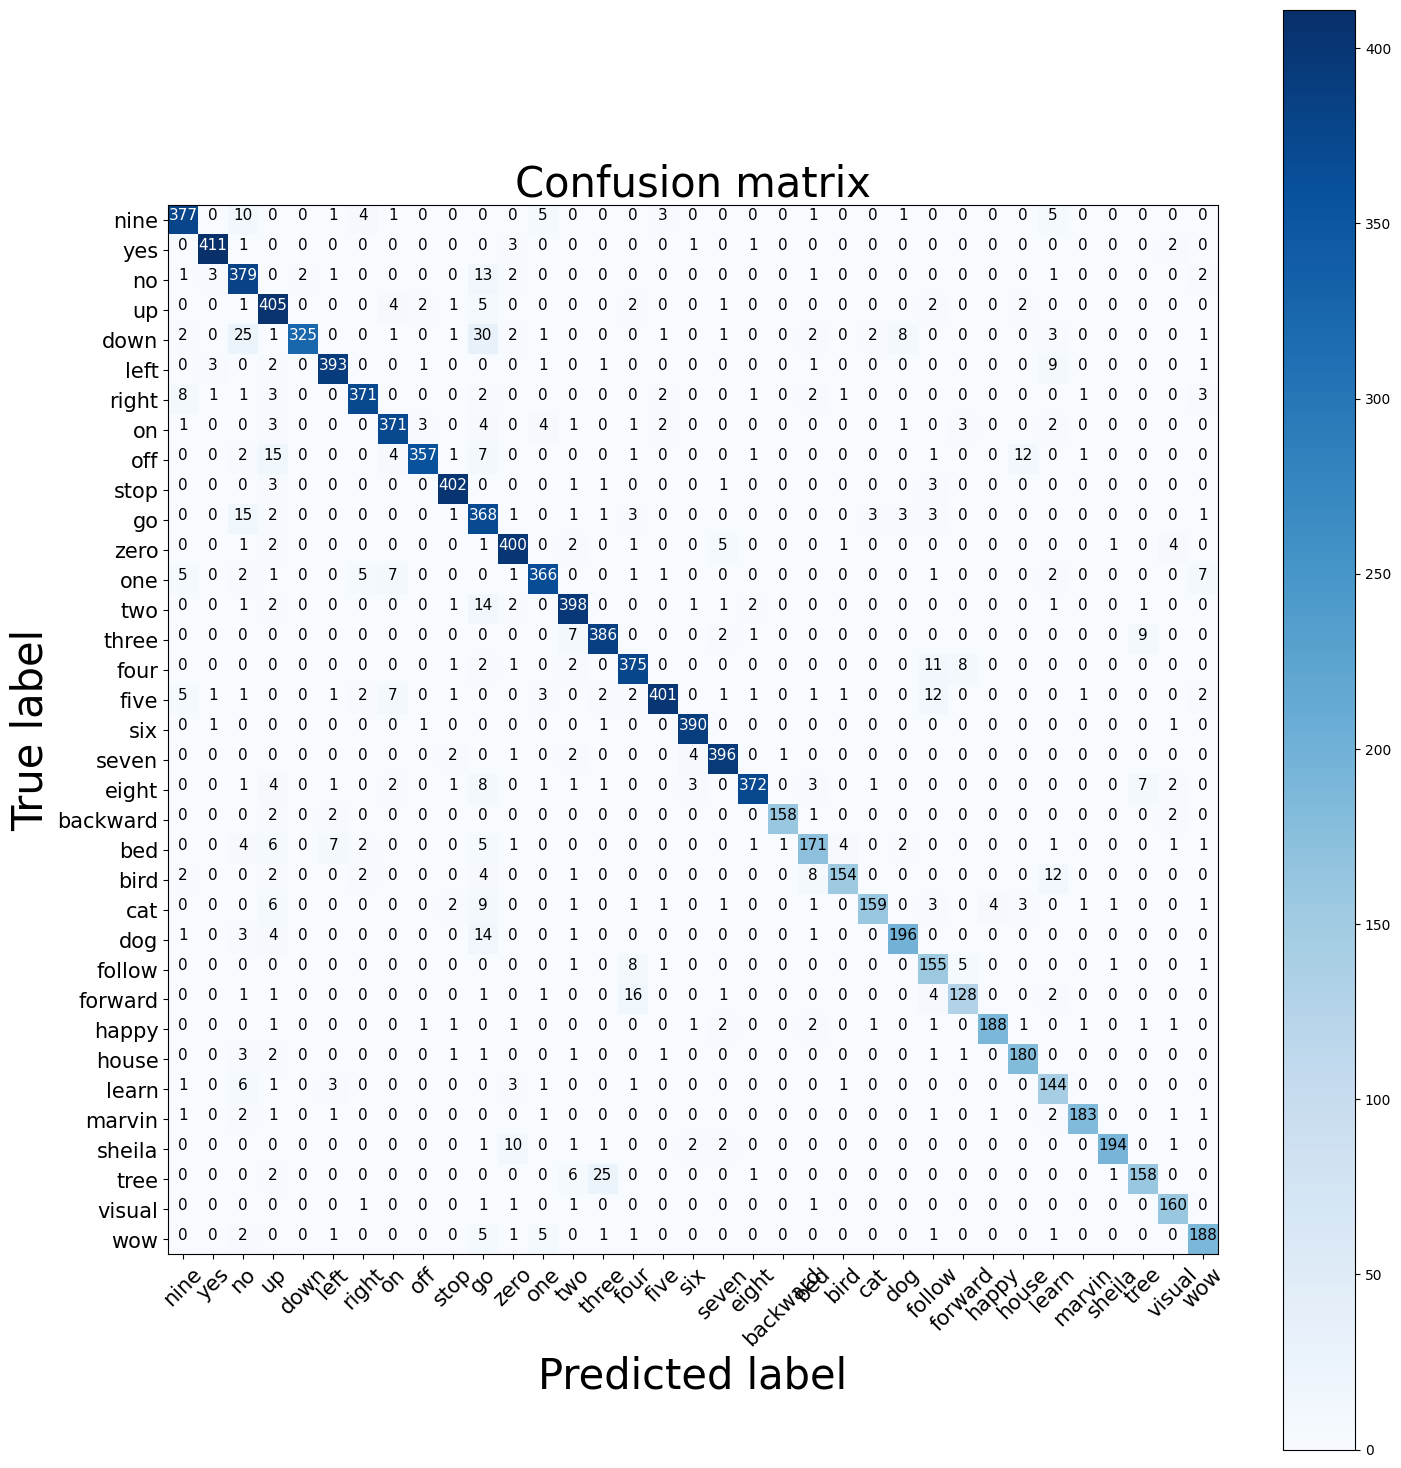

In [51]:
audioUtils.plot_confusion_matrix(cm, classes, normalize=False)

In [52]:
import pandas as pd
[tf.__version__, pd.__version__, librosa.__version__]

['2.19.0', '2.2.2', '0.11.0']

# Save model

In [53]:
model_16000 = SpeechModels.AttRNNSpeechModel(nCategs, samplingrate = sr, inputLength = None)
model_16000.load_weights('model-attRNN.h5')

tf.saved_model.save(model_16000, 'model-KWS-attRNN')

In [54]:
model_16000 = tf.saved_model.load('model-KWS-attRNN')

In [58]:
# Convert the model
converter = tf.lite.TFLiteConverter.from_saved_model('model-KWS-attRNN') # path to the SavedModel directory

converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS, tf.lite.OpsSet.SELECT_TF_OPS]
converter._experimental_lower_tensor_list_ops = False

tflite_model = converter.convert()

# Save the model.
with open('model-KWS-attRNN.tflite', 'wb') as f:
    f.write(tflite_model)

ConverterError: Could not translate MLIR to FlatBuffer.<unknown>:0: error: loc(callsite(callsite(fused["CudnnRNNV3:", "functional_3_1/bidirectional_2_1/backward_lstm_2_1/CudnnRNNV3@__inference_serving_default_610687"] at fused["StatefulPartitionedCall:", "StatefulPartitionedCall@__inference_signature_wrapper_serving_default_610757"]) at fused["StatefulPartitionedCall:", "StatefulPartitionedCall"])): 'tf.CudnnRNNV3' op is neither a custom op nor a flex op
<unknown>:0: note: loc(fused["StatefulPartitionedCall:", "StatefulPartitionedCall"]): called from
<unknown>:0: note: loc(callsite(callsite(fused["CudnnRNNV3:", "functional_3_1/bidirectional_2_1/backward_lstm_2_1/CudnnRNNV3@__inference_serving_default_610687"] at fused["StatefulPartitionedCall:", "StatefulPartitionedCall@__inference_signature_wrapper_serving_default_610757"]) at fused["StatefulPartitionedCall:", "StatefulPartitionedCall"])): see current operation: %1:5 = "tf.CudnnRNNV3"(%arg0, %arg1, %arg2, %arg3, %arg4) {T = f32, device = "", direction = "unidirectional", dropout = 0.000000e+00 : f32, input_mode = "linear_input", is_training = true, num_proj = 0 : i64, rnn_mode = "lstm", seed = 0 : i64, seed2 = 0 : i64, time_major = false} : (tensor<?x?x80xf32>, tensor<?x1x64xf32>, tensor<?x1x64xf32>, tensor<37376xf32>, tensor<?xi32>) -> (tensor<?x?x64xf32>, tensor<?x1x64xf32>, tensor<?x1x64xf32>, tensor<*xf32>, tensor<*xi8>)
<unknown>:0: note: loc(callsite(callsite(fused["CudnnRNNV3:", "functional_3_1/bidirectional_2_1/backward_lstm_2_1/CudnnRNNV3@__inference_serving_default_610687"] at fused["StatefulPartitionedCall:", "StatefulPartitionedCall@__inference_signature_wrapper_serving_default_610757"]) at fused["StatefulPartitionedCall:", "StatefulPartitionedCall"])): Error code: ERROR_NEEDS_CUSTOM_OPS
<unknown>:0: error: loc(callsite(callsite(fused["CudnnRNNV3:", "functional_3_1/bidirectional_2_1/forward_lstm_2_1/CudnnRNNV3@__inference_serving_default_610687"] at fused["StatefulPartitionedCall:", "StatefulPartitionedCall@__inference_signature_wrapper_serving_default_610757"]) at fused["StatefulPartitionedCall:", "StatefulPartitionedCall"])): 'tf.CudnnRNNV3' op is neither a custom op nor a flex op
<unknown>:0: note: loc(fused["StatefulPartitionedCall:", "StatefulPartitionedCall"]): called from
<unknown>:0: note: loc(callsite(callsite(fused["CudnnRNNV3:", "functional_3_1/bidirectional_2_1/forward_lstm_2_1/CudnnRNNV3@__inference_serving_default_610687"] at fused["StatefulPartitionedCall:", "StatefulPartitionedCall@__inference_signature_wrapper_serving_default_610757"]) at fused["StatefulPartitionedCall:", "StatefulPartitionedCall"])): see current operation: %1:5 = "tf.CudnnRNNV3"(%arg0, %arg1, %arg2, %arg3, %arg4) {T = f32, device = "", direction = "unidirectional", dropout = 0.000000e+00 : f32, input_mode = "linear_input", is_training = true, num_proj = 0 : i64, rnn_mode = "lstm", seed = 0 : i64, seed2 = 0 : i64, time_major = false} : (tensor<?x?x80xf32>, tensor<?x1x64xf32>, tensor<?x1x64xf32>, tensor<37376xf32>, tensor<?xi32>) -> (tensor<?x?x64xf32>, tensor<?x1x64xf32>, tensor<?x1x64xf32>, tensor<*xf32>, tensor<*xi8>)
<unknown>:0: note: loc(callsite(callsite(fused["CudnnRNNV3:", "functional_3_1/bidirectional_2_1/forward_lstm_2_1/CudnnRNNV3@__inference_serving_default_610687"] at fused["StatefulPartitionedCall:", "StatefulPartitionedCall@__inference_signature_wrapper_serving_default_610757"]) at fused["StatefulPartitionedCall:", "StatefulPartitionedCall"])): Error code: ERROR_NEEDS_CUSTOM_OPS
<unknown>:0: error: loc(callsite(callsite(fused["CudnnRNNV3:", "functional_3_1/bidirectional_3_1/backward_lstm_3_1/CudnnRNNV3@__inference_serving_default_610687"] at fused["StatefulPartitionedCall:", "StatefulPartitionedCall@__inference_signature_wrapper_serving_default_610757"]) at fused["StatefulPartitionedCall:", "StatefulPartitionedCall"])): 'tf.CudnnRNNV3' op is neither a custom op nor a flex op
<unknown>:0: note: loc(fused["StatefulPartitionedCall:", "StatefulPartitionedCall"]): called from
<unknown>:0: note: loc(callsite(callsite(fused["CudnnRNNV3:", "functional_3_1/bidirectional_3_1/backward_lstm_3_1/CudnnRNNV3@__inference_serving_default_610687"] at fused["StatefulPartitionedCall:", "StatefulPartitionedCall@__inference_signature_wrapper_serving_default_610757"]) at fused["StatefulPartitionedCall:", "StatefulPartitionedCall"])): see current operation: %1:5 = "tf.CudnnRNNV3"(%arg0, %arg1, %arg2, %arg3, %arg4) {T = f32, device = "", direction = "unidirectional", dropout = 0.000000e+00 : f32, input_mode = "linear_input", is_training = true, num_proj = 0 : i64, rnn_mode = "lstm", seed = 0 : i64, seed2 = 0 : i64, time_major = false} : (tensor<?x?x128xf32>, tensor<?x1x64xf32>, tensor<?x1x64xf32>, tensor<49664xf32>, tensor<?xi32>) -> (tensor<?x?x64xf32>, tensor<?x1x64xf32>, tensor<?x1x64xf32>, tensor<*xf32>, tensor<*xi8>)
<unknown>:0: note: loc(callsite(callsite(fused["CudnnRNNV3:", "functional_3_1/bidirectional_3_1/backward_lstm_3_1/CudnnRNNV3@__inference_serving_default_610687"] at fused["StatefulPartitionedCall:", "StatefulPartitionedCall@__inference_signature_wrapper_serving_default_610757"]) at fused["StatefulPartitionedCall:", "StatefulPartitionedCall"])): Error code: ERROR_NEEDS_CUSTOM_OPS
<unknown>:0: error: loc(callsite(callsite(fused["CudnnRNNV3:", "functional_3_1/bidirectional_3_1/forward_lstm_3_1/CudnnRNNV3@__inference_serving_default_610687"] at fused["StatefulPartitionedCall:", "StatefulPartitionedCall@__inference_signature_wrapper_serving_default_610757"]) at fused["StatefulPartitionedCall:", "StatefulPartitionedCall"])): 'tf.CudnnRNNV3' op is neither a custom op nor a flex op
<unknown>:0: note: loc(fused["StatefulPartitionedCall:", "StatefulPartitionedCall"]): called from
<unknown>:0: note: loc(callsite(callsite(fused["CudnnRNNV3:", "functional_3_1/bidirectional_3_1/forward_lstm_3_1/CudnnRNNV3@__inference_serving_default_610687"] at fused["StatefulPartitionedCall:", "StatefulPartitionedCall@__inference_signature_wrapper_serving_default_610757"]) at fused["StatefulPartitionedCall:", "StatefulPartitionedCall"])): see current operation: %1:5 = "tf.CudnnRNNV3"(%arg0, %arg1, %arg2, %arg3, %arg4) {T = f32, device = "", direction = "unidirectional", dropout = 0.000000e+00 : f32, input_mode = "linear_input", is_training = true, num_proj = 0 : i64, rnn_mode = "lstm", seed = 0 : i64, seed2 = 0 : i64, time_major = false} : (tensor<?x?x128xf32>, tensor<?x1x64xf32>, tensor<?x1x64xf32>, tensor<49664xf32>, tensor<?xi32>) -> (tensor<?x?x64xf32>, tensor<?x1x64xf32>, tensor<?x1x64xf32>, tensor<*xf32>, tensor<*xi8>)
<unknown>:0: note: loc(callsite(callsite(fused["CudnnRNNV3:", "functional_3_1/bidirectional_3_1/forward_lstm_3_1/CudnnRNNV3@__inference_serving_default_610687"] at fused["StatefulPartitionedCall:", "StatefulPartitionedCall@__inference_signature_wrapper_serving_default_610757"]) at fused["StatefulPartitionedCall:", "StatefulPartitionedCall"])): Error code: ERROR_NEEDS_CUSTOM_OPS
<unknown>:0: error: failed while converting: 'main': 
Some ops in the model are custom ops, See instructions to implement custom ops: https://www.tensorflow.org/lite/guide/ops_custom 
Custom ops: CudnnRNNV3
Details:
	tf.CudnnRNNV3(tensor<?x?x128xf32>, tensor<?x1x64xf32>, tensor<?x1x64xf32>, tensor<49664xf32>, tensor<?xi32>) -> (tensor<?x?x64xf32>, tensor<?x1x64xf32>, tensor<?x1x64xf32>, tensor<*xf32>, tensor<*xi8>) : {T = f32, device = "", direction = "unidirectional", dropout = 0.000000e+00 : f32, input_mode = "linear_input", is_training = true, num_proj = 0 : i64, rnn_mode = "lstm", seed = 0 : i64, seed2 = 0 : i64, time_major = false}
	tf.CudnnRNNV3(tensor<?x?x80xf32>, tensor<?x1x64xf32>, tensor<?x1x64xf32>, tensor<37376xf32>, tensor<?xi32>) -> (tensor<?x?x64xf32>, tensor<?x1x64xf32>, tensor<?x1x64xf32>, tensor<*xf32>, tensor<*xi8>) : {T = f32, device = "", direction = "unidirectional", dropout = 0.000000e+00 : f32, input_mode = "linear_input", is_training = true, num_proj = 0 : i64, rnn_mode = "lstm", seed = 0 : i64, seed2 = 0 : i64, time_major = false}

<unknown>:0: note: see current operation: 
"func.func"() <{arg_attrs = [{tf_saved_model.index_path = ["inputs"]}], function_type = (tensor<?x?xf32>) -> tensor<?x36xf32>, res_attrs = [{tf_saved_model.index_path = ["output_0"]}], sym_name = "main"}> ({
^bb0(%arg0: tensor<?x?xf32>):
  %0 = "arith.constant"() <{value = dense<[-1, 128]> : tensor<2xi32>}> : () -> tensor<2xi32>
  %1 = "arith.constant"() <{value = dense<[1, 5, 1, 10]> : tensor<4xi32>}> : () -> tensor<4xi32>
  %2 = "tfl.no_value"() <{value}> : () -> none
  %3 = "arith.constant"() <{value = dense<1> : tensor<3xi32>}> : () -> tensor<3xi32>
  %4 = "arith.constant"() <{value = dense<[0, 0, 128]> : tensor<3xi32>}> : () -> tensor<3xi32>
  %5 = "arith.constant"() <{value = dense<[0, -1, 0]> : tensor<3xi32>}> : () -> tensor<3xi32>
  %6 = "arith.constant"() <{value = dense<0.000000e+00> : tensor<1xf32>}> : () -> tensor<1xf32>
  %7 = "arith.constant"() <{value = dense<[3, 0, 1, 2]> : tensor<4xi32>}> : () -> tensor<4xi32>
  %8 = "arith.constant"() <{value = dense<0.000000e+00> : tensor<10xf32>}> : () -> tensor<10xf32>
  %9 = "arith.constant"() <{value = dense<[1, 1024]> : tensor<2xi32>}> : () -> tensor<2xi32>
  %10 = "arith.constant"() <{value = dense<-2> : tensor<i32>}> : () -> tensor<i32>
  %11 = "arith.constant"() <{value = dense<[1, 0]> : tensor<2xi32>}> : () -> tensor<2xi32>
  %12 = "arith.constant"() <{value = dense_resource<__elided__> : tensor<80x513xf32>}> : () -> tensor<80x513xf32>
  %13 = "arith.constant"() <{value = dense_resource<__elided__> : tensor<1024xf32>}> : () -> tensor<1024xf32>
  %14 = "arith.constant"() <{value = dense<[[0, 1, 2, 3, 4, 5, 6, 7]]> : tensor<1x8xi32>}> : () -> tensor<1x8xi32>
  %15 = "arith.constant"() <{value = dense<0> : tensor<1x2xi32>}> : () -> tensor<1x2xi32>
  %16 = "arith.constant"() <{value = dense<[1, 1, 0]> : tensor<3xi32>}> : () -> tensor<3xi32>
  %17 = "arith.constant"() <{value = dense<[0, 1]> : tensor<2xi32>}> : () -> tensor<2xi32>
  %18 = "arith.constant"() <{value = dense<80> : tensor<1xi32>}> : () -> tensor<1xi32>
  %19 = "arith.constant"() <{value = dense<[0, 1, 2]> : tensor<3xi32>}> : () -> tensor<3xi32>
  %20 = "arith.constant"() <{value = dense<1> : tensor<2xi32>}> : () -> tensor<2xi32>
  %21 = "arith.constant"() <{value = dense<0> : tensor<2xi32>}> : () -> tensor<2xi32>
  %22 = "arith.constant"() <{value = dense<1> : tensor<4xi32>}> : () -> tensor<4xi32>
  %23 = "arith.constant"() <{value = dense<-1> : tensor<i32>}> : () -> tensor<i32>
  %24 = "arith.constant"() <{value = dense<0.000000e+00> : tensor<256xf32>}> : () -> tensor<256xf32>
  %25 = "arith.constant"() <{value = dense<64> : tensor<i32>}> : () -> tensor<i32>
  %26 = "arith.constant"() <{value = dense<0.000000e+00> : tensor<f32>}> : () -> tensor<f32>
  %27 = "arith.constant"() <{value = dense<2> : tensor<1xi32>}> : () -> tensor<1xi32>
  %28 = "arith.constant"() <{value = dense<0> : tensor<1xi32>}> : () -> tensor<1xi32>
  %29 = "arith.constant"() <{value = dense<0> : tensor<i32>}> : () -> tensor<i32>
  %30 = "arith.constant"() <{value = dense<1> : tensor<i32>}> : () -> tensor<i32>
  %31 = "arith.constant"() <{value = dense<-1> : tensor<1xi32>}> : () -> tensor<1xi32>
  %32 = "arith.constant"() <{value = dense<1> : tensor<1xi32>}> : () -> tensor<1xi32>
  %33 = "arith.constant"() <{value = dense<1.000000e-03> : tensor<f32>}> : () -> tensor<f32>
  %34 = "arith.constant"() <{value = dense<9.99999997E-7> : tensor<f32>}> : () -> tensor<f32>
  %35 = "arith.constant"() <{value = dense<> : tensor<0xi32>}> : () -> tensor<0xi32>
  %36 = "arith.constant"() <{value = dense<128> : tensor<i32>}> : () -> tensor<i32>
  %37 = "arith.constant"() <{value = dense<1024> : tensor<i32>}> : () -> tensor<i32>
  %38 = "arith.constant"() <{value = dense<[1, 2]> : tensor<2xi32>}> : () -> tensor<2xi32>
  %39 = "tfl.var_handle"() <{container = "", shared_name = "batch_normalization_2/beta"}> : () -> tensor<!tf_type.resource<tensor<10xf32>>>
  %40 = "tfl.var_handle"() <{container = "", shared_name = "batch_normalization_2/gamma"}> : () -> tensor<!tf_type.resource<tensor<10xf32>>>
  %41 = "tfl.var_handle"() <{container = "", shared_name = "batch_normalization_2/moving_mean"}> : () -> tensor<!tf_type.resource<tensor<10xf32>>>
  %42 = "tfl.var_handle"() <{container = "", shared_name = "batch_normalization_2/moving_variance"}> : () -> tensor<!tf_type.resource<tensor<10xf32>>>
  %43 = "tfl.var_handle"() <{container = "", shared_name = "batch_normalization_3/beta"}> : () -> tensor<!tf_type.resource<tensor<1xf32>>>
  %44 = "tfl.var_handle"() <{container = "", shared_name = "batch_normalization_3/gamma"}> : () -> tensor<!tf_type.resource<tensor<1xf32>>>
  %45 = "tfl.var_handle"() <{container = "", shared_name = "batch_normalization_3/moving_mean"}> : () -> tensor<!tf_type.resource<tensor<1xf32>>>
  %46 = "tfl.var_handle"() <{container = "", shared_name = "batch_normalization_3/moving_variance"}> : () -> tensor<!tf_type.resource<tensor<1xf32>>>
  %47 = "tfl.var_handle"() <{container = "", shared_name = "bidirectional_2/backward_lstm_2/lstm_cell/bias"}> : () -> tensor<!tf_type.resource<tensor<256xf32>>>
  %48 = "tfl.var_handle"() <{container = "", shared_name = "bidirectional_2/backward_lstm_2/lstm_cell/kernel"}> : () -> tensor<!tf_type.resource<tensor<80x256xf32>>>
  %49 = "tfl.var_handle"() <{container = "", shared_name = "bidirectional_2/backward_lstm_2/lstm_cell/recurrent_kernel"}> : () -> tensor<!tf_type.resource<tensor<64x256xf32>>>
  %50 = "tfl.var_handle"() <{container = "", shared_name = "bidirectional_2/forward_lstm_2/lstm_cell/bias"}> : () -> tensor<!tf_type.resource<tensor<256xf32>>>
  %51 = "tfl.var_handle"() <{container = "", shared_name = "bidirectional_2/forward_lstm_2/lstm_cell/kernel"}> : () -> tensor<!tf_type.resource<tensor<80x256xf32>>>
  %52 = "tfl.var_handle"() <{container = "", shared_name = "bidirectional_2/forward_lstm_2/lstm_cell/recurrent_kernel"}> : () -> tensor<!tf_type.resource<tensor<64x256xf32>>>
  %53 = "tfl.var_handle"() <{container = "", shared_name = "bidirectional_3/backward_lstm_3/lstm_cell/bias"}> : () -> tensor<!tf_type.resource<tensor<256xf32>>>
  %54 = "tfl.var_handle"() <{container = "", shared_name = "bidirectional_3/backward_lstm_3/lstm_cell/kernel"}> : () -> tensor<!tf_type.resource<tensor<128x256xf32>>>
  %55 = "tfl.var_handle"() <{container = "", shared_name = "bidirectional_3/backward_lstm_3/lstm_cell/recurrent_kernel"}> : () -> tensor<!tf_type.resource<tensor<64x256xf32>>>
  %56 = "tfl.var_handle"() <{container = "", shared_name = "bidirectional_3/forward_lstm_3/lstm_cell/bias"}> : () -> tensor<!tf_type.resource<tensor<256xf32>>>
  %57 = "tfl.var_handle"() <{container = "", shared_name = "bidirectional_3/forward_lstm_3/lstm_cell/kernel"}> : () -> tensor<!tf_type.resource<tensor<128x256xf32>>>
  %58 = "tfl.var_handle"() <{container = "", shared_name = "bidirectional_3/forward_lstm_3/lstm_cell/recurrent_kernel"}> : () -> tensor<!tf_type.resource<tensor<64x256xf32>>>
  %59 = "tfl.var_handle"() <{container = "", shared_name = "conv2d_2/bias"}> : () -> tensor<!tf_type.resource<tensor<10xf32>>>
  %60 = "tfl.var_handle"() <{container = "", shared_name = "conv2d_2/kernel"}> : () -> tensor<!tf_type.resource<tensor<5x1x1x10xf32>>>
  %61 = "tfl.var_handle"() <{container = "", shared_name = "conv2d_3/bias"}> : () -> tensor<!tf_type.resource<tensor<1xf32>>>
  %62 = "tfl.var_handle"() <{container = "", shared_name = "conv2d_3/kernel"}> : () -> tensor<!tf_type.resource<tensor<5x1x10x1xf32>>>
  %63 = "tfl.var_handle"() <{container = "", shared_name = "dense_3/bias"}> : () -> tensor<!tf_type.resource<tensor<128xf32>>>
  %64 = "tfl.var_handle"() <{container = "", shared_name = "dense_3/kernel"}> : () -> tensor<!tf_type.resource<tensor<128x128xf32>>>
  %65 = "tfl.var_handle"() <{container = "", shared_name = "dense_4/bias"}> : () -> tensor<!tf_type.resource<tensor<64xf32>>>
  %66 = "tfl.var_handle"() <{container = "", shared_name = "dense_4/kernel"}> : () -> tensor<!tf_type.resource<tensor<128x64xf32>>>
  %67 = "tfl.var_handle"() <{container = "", shared_name = "dense_5/bias"}> : () -> tensor<!tf_type.resource<tensor<32xf32>>>
  %68 = "tfl.var_handle"() <{container = "", shared_name = "dense_5/kernel"}> : () -> tensor<!tf_type.resource<tensor<64x32xf32>>>
  %69 = "tfl.var_handle"() <{container = "", shared_name = "output/bias"}> : () -> tensor<!tf_type.resource<tensor<36xf32>>>
  %70 = "tfl.var_handle"() <{container = "", shared_name = "output/kernel"}> : () -> tensor<!tf_type.resource<tensor<32x36xf32>>>
  %71 = "tfl.read_variable"(%42) : (tensor<!tf_type.resource<tensor<10xf32>>>) -> tensor<10xf32>
  %72 = "tfl.add"(%71, %33) <{fused_activation_function = "NONE"}> : (tensor<10xf32>, tensor<f32>) -> tensor<10xf32>
  %73 = "tfl.rsqrt"(%72) : (tensor<10xf32>) -> tensor<10xf32>
  %74 = "tfl.read_variable"(%40) : (tensor<!tf_type.resource<tensor<10xf32>>>) -> tensor<10xf32>
  %75 = "tfl.mul"(%73, %74) <{fused_activation_function = "NONE"}> : (tensor<10xf32>, tensor<10xf32>) -> tensor<10xf32>
  %76 = "tfl.read_variable"(%39) : (tensor<!tf_type.resource<tensor<10xf32>>>) -> tensor<10xf32>
  %77 = "tfl.read_variable"(%41) : (tensor<!tf_type.resource<tensor<10xf32>>>) -> tensor<10xf32>
  %78 = "tfl.mul"(%77, %75) <{fused_activation_function = "NONE"}> : (tensor<10xf32>, tensor<10xf32>) -> tensor<10xf32>
  %79 = "tfl.sub"(%76, %78) <{fused_activation_function = "NONE"}> : (tensor<10xf32>, tensor<10xf32>) -> tensor<10xf32>
  %80 = "tfl.read_variable"(%46) : (tensor<!tf_type.resource<tensor<1xf32>>>) -> tensor<1xf32>
  %81 = "tfl.add"(%80, %33) <{fused_activation_function = "NONE"}> : (tensor<1xf32>, tensor<f32>) -> tensor<1xf32>
  %82 = "tfl.rsqrt"(%81) : (tensor<1xf32>) -> tensor<1xf32>
  %83 = "tfl.read_variable"(%44) : (tensor<!tf_type.resource<tensor<1xf32>>>) -> tensor<1xf32>
  %84 = "tfl.mul"(%82, %83) <{fused_activation_function = "NONE"}> : (tensor<1xf32>, tensor<1xf32>) -> tensor<1xf32>
  %85 = "tfl.read_variable"(%43) : (tensor<!tf_type.resource<tensor<1xf32>>>) -> tensor<1xf32>
  %86 = "tfl.read_variable"(%45) : (tensor<!tf_type.resource<tensor<1xf32>>>) -> tensor<1xf32>
  %87 = "tfl.mul"(%86, %84) <{fused_activation_function = "NONE"}> : (tensor<1xf32>, tensor<1xf32>) -> tensor<1xf32>
  %88 = "tfl.sub"(%85, %87) <{fused_activation_function = "NONE"}> : (tensor<1xf32>, tensor<1xf32>) -> tensor<1xf32>
  %89 = "tfl.read_variable"(%47) : (tensor<!tf_type.resource<tensor<256xf32>>>) -> tensor<256xf32>
  %90 = "tfl.concatenation"(%24, %89) <{axis = 0 : i32, fused_activation_function = "NONE"}> : (tensor<256xf32>, tensor<256xf32>) -> tensor<512xf32>
  %91:8 = "tfl.split"(%29, %90) <{num_splits = 8 : i32}> : (tensor<i32>, tensor<512xf32>) -> (tensor<64xf32>, tensor<64xf32>, tensor<64xf32>, tensor<64xf32>, tensor<64xf32>, tensor<64xf32>, tensor<64xf32>, tensor<64xf32>)
  %92 = "tfl.read_variable"(%49) : (tensor<!tf_type.resource<tensor<64x256xf32>>>) -> tensor<64x256xf32>
  %93:4 = "tfl.split"(%30, %92) <{num_splits = 4 : i32}> : (tensor<i32>, tensor<64x256xf32>) -> (tensor<64x64xf32>, tensor<64x64xf32>, tensor<64x64xf32>, tensor<64x64xf32>)
  %94 = "tfl.transpose"(%93#0, %11) : (tensor<64x64xf32>, tensor<2xi32>) -> tensor<64x64xf32>
  %95 = "tfl.reshape"(%94, %31) : (tensor<64x64xf32>, tensor<1xi32>) -> tensor<4096xf32>
  %96 = "tfl.transpose"(%93#1, %11) : (tensor<64x64xf32>, tensor<2xi32>) -> tensor<64x64xf32>
  %97 = "tfl.reshape"(%96, %31) : (tensor<64x64xf32>, tensor<1xi32>) -> tensor<4096xf32>
  %98 = "tfl.transpose"(%93#2, %11) : (tensor<64x64xf32>, tensor<2xi32>) -> tensor<64x64xf32>
  %99 = "tfl.reshape"(%98, %31) : (tensor<64x64xf32>, tensor<1xi32>) -> tensor<4096xf32>
  %100 = "tfl.transpose"(%93#3, %11) : (tensor<64x64xf32>, tensor<2xi32>) -> tensor<64x64xf32>
  %101 = "tfl.reshape"(%100, %31) : (tensor<64x64xf32>, tensor<1xi32>) -> tensor<4096xf32>
  %102 = "tfl.read_variable"(%48) : (tensor<!tf_type.resource<tensor<80x256xf32>>>) -> tensor<80x256xf32>
  %103:4 = "tfl.split"(%30, %102) <{num_splits = 4 : i32}> : (tensor<i32>, tensor<80x256xf32>) -> (tensor<80x64xf32>, tensor<80x64xf32>, tensor<80x64xf32>, tensor<80x64xf32>)
  %104 = "tfl.transpose"(%103#0, %11) : (tensor<80x64xf32>, tensor<2xi32>) -> tensor<64x80xf32>
  %105 = "tfl.reshape"(%104, %31) : (tensor<64x80xf32>, tensor<1xi32>) -> tensor<5120xf32>
  %106 = "tfl.transpose"(%103#1, %11) : (tensor<80x64xf32>, tensor<2xi32>) -> tensor<64x80xf32>
  %107 = "tfl.reshape"(%106, %31) : (tensor<64x80xf32>, tensor<1xi32>) -> tensor<5120xf32>
  %108 = "tfl.transpose"(%103#2, %11) : (tensor<80x64xf32>, tensor<2xi32>) -> tensor<64x80xf32>
  %109 = "tfl.reshape"(%108, %31) : (tensor<64x80xf32>, tensor<1xi32>) -> tensor<5120xf32>
  %110 = "tfl.transpose"(%103#3, %11) : (tensor<80x64xf32>, tensor<2xi32>) -> tensor<64x80xf32>
  %111 = "tfl.reshape"(%110, %31) : (tensor<64x80xf32>, tensor<1xi32>) -> tensor<5120xf32>
  %112 = "tfl.concatenation"(%105, %107, %109, %111, %95, %97, %99, %101, %91#0, %91#1, %91#2, %91#3, %91#4, %91#5, %91#6, %91#7) <{axis = 0 : i32, fused_activation_function = "NONE"}> : (tensor<5120xf32>, tensor<5120xf32>, tensor<5120xf32>, tensor<5120xf32>, tensor<4096xf32>, tensor<4096xf32>, tensor<4096xf32>, tensor<4096xf32>, tensor<64xf32>, tensor<64xf32>, tensor<64xf32>, tensor<64xf32>, tensor<64xf32>, tensor<64xf32>, tensor<64xf32>, tensor<64xf32>) -> tensor<37376xf32>
  %113 = "tfl.read_variable"(%50) : (tensor<!tf_type.resource<tensor<256xf32>>>) -> tensor<256xf32>
  %114 = "tfl.concatenation"(%24, %113) <{axis = 0 : i32, fused_activation_function = "NONE"}> : (tensor<256xf32>, tensor<256xf32>) -> tensor<512xf32>
  %115:8 = "tfl.split"(%29, %114) <{num_splits = 8 : i32}> : (tensor<i32>, tensor<512xf32>) -> (tensor<64xf32>, tensor<64xf32>, tensor<64xf32>, tensor<64xf32>, tensor<64xf32>, tensor<64xf32>, tensor<64xf32>, tensor<64xf32>)
  %116 = "tfl.read_variable"(%52) : (tensor<!tf_type.resource<tensor<64x256xf32>>>) -> tensor<64x256xf32>
  %117:4 = "tfl.split"(%30, %116) <{num_splits = 4 : i32}> : (tensor<i32>, tensor<64x256xf32>) -> (tensor<64x64xf32>, tensor<64x64xf32>, tensor<64x64xf32>, tensor<64x64xf32>)
  %118 = "tfl.transpose"(%117#0, %11) : (tensor<64x64xf32>, tensor<2xi32>) -> tensor<64x64xf32>
  %119 = "tfl.reshape"(%118, %31) : (tensor<64x64xf32>, tensor<1xi32>) -> tensor<4096xf32>
  %120 = "tfl.transpose"(%117#1, %11) : (tensor<64x64xf32>, tensor<2xi32>) -> tensor<64x64xf32>
  %121 = "tfl.reshape"(%120, %31) : (tensor<64x64xf32>, tensor<1xi32>) -> tensor<4096xf32>
  %122 = "tfl.transpose"(%117#2, %11) : (tensor<64x64xf32>, tensor<2xi32>) -> tensor<64x64xf32>
  %123 = "tfl.reshape"(%122, %31) : (tensor<64x64xf32>, tensor<1xi32>) -> tensor<4096xf32>
  %124 = "tfl.transpose"(%117#3, %11) : (tensor<64x64xf32>, tensor<2xi32>) -> tensor<64x64xf32>
  %125 = "tfl.reshape"(%124, %31) : (tensor<64x64xf32>, tensor<1xi32>) -> tensor<4096xf32>
  %126 = "tfl.read_variable"(%51) : (tensor<!tf_type.resource<tensor<80x256xf32>>>) -> tensor<80x256xf32>
  %127:4 = "tfl.split"(%30, %126) <{num_splits = 4 : i32}> : (tensor<i32>, tensor<80x256xf32>) -> (tensor<80x64xf32>, tensor<80x64xf32>, tensor<80x64xf32>, tensor<80x64xf32>)
  %128 = "tfl.transpose"(%127#0, %11) : (tensor<80x64xf32>, tensor<2xi32>) -> tensor<64x80xf32>
  %129 = "tfl.reshape"(%128, %31) : (tensor<64x80xf32>, tensor<1xi32>) -> tensor<5120xf32>
  %130 = "tfl.transpose"(%127#1, %11) : (tensor<80x64xf32>, tensor<2xi32>) -> tensor<64x80xf32>
  %131 = "tfl.reshape"(%130, %31) : (tensor<64x80xf32>, tensor<1xi32>) -> tensor<5120xf32>
  %132 = "tfl.transpose"(%127#2, %11) : (tensor<80x64xf32>, tensor<2xi32>) -> tensor<64x80xf32>
  %133 = "tfl.reshape"(%132, %31) : (tensor<64x80xf32>, tensor<1xi32>) -> tensor<5120xf32>
  %134 = "tfl.transpose"(%127#3, %11) : (tensor<80x64xf32>, tensor<2xi32>) -> tensor<64x80xf32>
  %135 = "tfl.reshape"(%134, %31) : (tensor<64x80xf32>, tensor<1xi32>) -> tensor<5120xf32>
  %136 = "tfl.concatenation"(%129, %131, %133, %135, %119, %121, %123, %125, %115#0, %115#1, %115#2, %115#3, %115#4, %115#5, %115#6, %115#7) <{axis = 0 : i32, fused_activation_function = "NONE"}> : (tensor<5120xf32>, tensor<5120xf32>, tensor<5120xf32>, tensor<5120xf32>, tensor<4096xf32>, tensor<4096xf32>, tensor<4096xf32>, tensor<4096xf32>, tensor<64xf32>, tensor<64xf32>, tensor<64xf32>, tensor<64xf32>, tensor<64xf32>, tensor<64xf32>, tensor<64xf32>, tensor<64xf32>) -> tensor<37376xf32>
  %137 = "tfl.read_variable"(%53) : (tensor<!tf_type.resource<tensor<256xf32>>>) -> tensor<256xf32>
  %138 = "tfl.concatenation"(%24, %137) <{axis = 0 : i32, fused_activation_function = "NONE"}> : (tensor<256xf32>, tensor<256xf32>) -> tensor<512xf32>
  %139:8 = "tfl.split"(%29, %138) <{num_splits = 8 : i32}> : (tensor<i32>, tensor<512xf32>) -> (tensor<64xf32>, tensor<64xf32>, tensor<64xf32>, tensor<64xf32>, tensor<64xf32>, tensor<64xf32>, tensor<64xf32>, tensor<64xf32>)
  %140 = "tfl.read_variable"(%55) : (tensor<!tf_type.resource<tensor<64x256xf32>>>) -> tensor<64x256xf32>
  %141:4 = "tfl.split"(%30, %140) <{num_splits = 4 : i32}> : (tensor<i32>, tensor<64x256xf32>) -> (tensor<64x64xf32>, tensor<64x64xf32>, tensor<64x64xf32>, tensor<64x64xf32>)
  %142 = "tfl.transpose"(%141#0, %11) : (tensor<64x64xf32>, tensor<2xi32>) -> tensor<64x64xf32>
  %143 = "tfl.reshape"(%142, %31) : (tensor<64x64xf32>, tensor<1xi32>) -> tensor<4096xf32>
  %144 = "tfl.transpose"(%141#1, %11) : (tensor<64x64xf32>, tensor<2xi32>) -> tensor<64x64xf32>
  %145 = "tfl.reshape"(%144, %31) : (tensor<64x64xf32>, tensor<1xi32>) -> tensor<4096xf32>
  %146 = "tfl.transpose"(%141#2, %11) : (tensor<64x64xf32>, tensor<2xi32>) -> tensor<64x64xf32>
  %147 = "tfl.reshape"(%146, %31) : (tensor<64x64xf32>, tensor<1xi32>) -> tensor<4096xf32>
  %148 = "tfl.transpose"(%141#3, %11) : (tensor<64x64xf32>, tensor<2xi32>) -> tensor<64x64xf32>
  %149 = "tfl.reshape"(%148, %31) : (tensor<64x64xf32>, tensor<1xi32>) -> tensor<4096xf32>
  %150 = "tfl.read_variable"(%54) : (tensor<!tf_type.resource<tensor<128x256xf32>>>) -> tensor<128x256xf32>
  %151:4 = "tfl.split"(%30, %150) <{num_splits = 4 : i32}> : (tensor<i32>, tensor<128x256xf32>) -> (tensor<128x64xf32>, tensor<128x64xf32>, tensor<128x64xf32>, tensor<128x64xf32>)
  %152 = "tfl.transpose"(%151#0, %11) : (tensor<128x64xf32>, tensor<2xi32>) -> tensor<64x128xf32>
  %153 = "tfl.reshape"(%152, %31) : (tensor<64x128xf32>, tensor<1xi32>) -> tensor<8192xf32>
  %154 = "tfl.transpose"(%151#1, %11) : (tensor<128x64xf32>, tensor<2xi32>) -> tensor<64x128xf32>
  %155 = "tfl.reshape"(%154, %31) : (tensor<64x128xf32>, tensor<1xi32>) -> tensor<8192xf32>
  %156 = "tfl.transpose"(%151#2, %11) : (tensor<128x64xf32>, tensor<2xi32>) -> tensor<64x128xf32>
  %157 = "tfl.reshape"(%156, %31) : (tensor<64x128xf32>, tensor<1xi32>) -> tensor<8192xf32>
  %158 = "tfl.transpose"(%151#3, %11) : (tensor<128x64xf32>, tensor<2xi32>) -> tensor<64x128xf32>
  %159 = "tfl.reshape"(%158, %31) : (tensor<64x128xf32>, tensor<1xi32>) -> tensor<8192xf32>
  %160 = "tfl.concatenation"(%153, %155, %157, %159, %143, %145, %147, %149, %139#0, %139#1, %139#2, %139#3, %139#4, %139#5, %139#6, %139#7) <{axis = 0 : i32, fused_activation_function = "NONE"}> : (tensor<8192xf32>, tensor<8192xf32>, tensor<8192xf32>, tensor<8192xf32>, tensor<4096xf32>, tensor<4096xf32>, tensor<4096xf32>, tensor<4096xf32>, tensor<64xf32>, tensor<64xf32>, tensor<64xf32>, tensor<64xf32>, tensor<64xf32>, tensor<64xf32>, tensor<64xf32>, tensor<64xf32>) -> tensor<49664xf32>
  %161 = "tfl.read_variable"(%56) : (tensor<!tf_type.resource<tensor<256xf32>>>) -> tensor<256xf32>
  %162 = "tfl.concatenation"(%24, %161) <{axis = 0 : i32, fused_activation_function = "NONE"}> : (tensor<256xf32>, tensor<256xf32>) -> tensor<512xf32>
  %163:8 = "tfl.split"(%29, %162) <{num_splits = 8 : i32}> : (tensor<i32>, tensor<512xf32>) -> (tensor<64xf32>, tensor<64xf32>, tensor<64xf32>, tensor<64xf32>, tensor<64xf32>, tensor<64xf32>, tensor<64xf32>, tensor<64xf32>)
  %164 = "tfl.read_variable"(%58) : (tensor<!tf_type.resource<tensor<64x256xf32>>>) -> tensor<64x256xf32>
  %165:4 = "tfl.split"(%30, %164) <{num_splits = 4 : i32}> : (tensor<i32>, tensor<64x256xf32>) -> (tensor<64x64xf32>, tensor<64x64xf32>, tensor<64x64xf32>, tensor<64x64xf32>)
  %166 = "tfl.transpose"(%165#0, %11) : (tensor<64x64xf32>, tensor<2xi32>) -> tensor<64x64xf32>
  %167 = "tfl.reshape"(%166, %31) : (tensor<64x64xf32>, tensor<1xi32>) -> tensor<4096xf32>
  %168 = "tfl.transpose"(%165#1, %11) : (tensor<64x64xf32>, tensor<2xi32>) -> tensor<64x64xf32>
  %169 = "tfl.reshape"(%168, %31) : (tensor<64x64xf32>, tensor<1xi32>) -> tensor<4096xf32>
  %170 = "tfl.transpose"(%165#2, %11) : (tensor<64x64xf32>, tensor<2xi32>) -> tensor<64x64xf32>
  %171 = "tfl.reshape"(%170, %31) : (tensor<64x64xf32>, tensor<1xi32>) -> tensor<4096xf32>
  %172 = "tfl.transpose"(%165#3, %11) : (tensor<64x64xf32>, tensor<2xi32>) -> tensor<64x64xf32>
  %173 = "tfl.reshape"(%172, %31) : (tensor<64x64xf32>, tensor<1xi32>) -> tensor<4096xf32>
  %174 = "tfl.read_variable"(%57) : (tensor<!tf_type.resource<tensor<128x256xf32>>>) -> tensor<128x256xf32>
  %175:4 = "tfl.split"(%30, %174) <{num_splits = 4 : i32}> : (tensor<i32>, tensor<128x256xf32>) -> (tensor<128x64xf32>, tensor<128x64xf32>, tensor<128x64xf32>, tensor<128x64xf32>)
  %176 = "tfl.transpose"(%175#0, %11) : (tensor<128x64xf32>, tensor<2xi32>) -> tensor<64x128xf32>
  %177 = "tfl.reshape"(%176, %31) : (tensor<64x128xf32>, tensor<1xi32>) -> tensor<8192xf32>
  %178 = "tfl.transpose"(%175#1, %11) : (tensor<128x64xf32>, tensor<2xi32>) -> tensor<64x128xf32>
  %179 = "tfl.reshape"(%178, %31) : (tensor<64x128xf32>, tensor<1xi32>) -> tensor<8192xf32>
  %180 = "tfl.transpose"(%175#2, %11) : (tensor<128x64xf32>, tensor<2xi32>) -> tensor<64x128xf32>
  %181 = "tfl.reshape"(%180, %31) : (tensor<64x128xf32>, tensor<1xi32>) -> tensor<8192xf32>
  %182 = "tfl.transpose"(%175#3, %11) : (tensor<128x64xf32>, tensor<2xi32>) -> tensor<64x128xf32>
  %183 = "tfl.reshape"(%182, %31) : (tensor<64x128xf32>, tensor<1xi32>) -> tensor<8192xf32>
  %184 = "tfl.concatenation"(%177, %179, %181, %183, %167, %169, %171, %173, %163#0, %163#1, %163#2, %163#3, %163#4, %163#5, %163#6, %163#7) <{axis = 0 : i32, fused_activation_function = "NONE"}> : (tensor<8192xf32>, tensor<8192xf32>, tensor<8192xf32>, tensor<8192xf32>, tensor<4096xf32>, tensor<4096xf32>, tensor<4096xf32>, tensor<4096xf32>, tensor<64xf32>, tensor<64xf32>, tensor<64xf32>, tensor<64xf32>, tensor<64xf32>, tensor<64xf32>, tensor<64xf32>, tensor<64xf32>) -> tensor<49664xf32>
  %185 = "tfl.read_variable"(%60) : (tensor<!tf_type.resource<tensor<5x1x1x10xf32>>>) -> tensor<5x1x1x10xf32>
  %186 = "tfl.read_variable"(%59) : (tensor<!tf_type.resource<tensor<10xf32>>>) -> tensor<10xf32>
  %187 = "tfl.read_variable"(%62) : (tensor<!tf_type.resource<tensor<5x1x10x1xf32>>>) -> tensor<5x1x10x1xf32>
  %188 = "tfl.read_variable"(%61) : (tensor<!tf_type.resource<tensor<1xf32>>>) -> tensor<1xf32>
  %189 = "tfl.reshape"(%188, %22) : (tensor<1xf32>, tensor<4xi32>) -> tensor<1x1x1x1xf32>
  %190 = "tfl.read_variable"(%63) : (tensor<!tf_type.resource<tensor<128xf32>>>) -> tensor<128xf32>
  %191 = "tfl.read_variable"(%64) : (tensor<!tf_type.resource<tensor<128x128xf32>>>) -> tensor<128x128xf32>
  %192 = "tfl.read_variable"(%65) : (tensor<!tf_type.resource<tensor<64xf32>>>) -> tensor<64xf32>
  %193 = "tfl.read_variable"(%66) : (tensor<!tf_type.resource<tensor<128x64xf32>>>) -> tensor<128x64xf32>
  %194 = "tfl.read_variable"(%67) : (tensor<!tf_type.resource<tensor<32xf32>>>) -> tensor<32xf32>
  %195 = "tfl.read_variable"(%68) : (tensor<!tf_type.resource<tensor<64x32xf32>>>) -> tensor<64x32xf32>
  %196 = "tfl.read_variable"(%69) : (tensor<!tf_type.resource<tensor<36xf32>>>) -> tensor<36xf32>
  %197 = "tfl.read_variable"(%70) : (tensor<!tf_type.resource<tensor<32x36xf32>>>) -> tensor<32x36xf32>
  %198 = "tfl.shape"(%arg0) : (tensor<?x?xf32>) -> tensor<2xi32>
  %199:3 = "tfl.split_v"(%198, %16, %29) <{num_splits = 3 : i32}> : (tensor<2xi32>, tensor<3xi32>, tensor<i32>) -> (tensor<1xi32>, tensor<1xi32>, tensor<0xi32>)
  %200 = "tfl.reshape"(%199#1, %35) : (tensor<1xi32>, tensor<0xi32>) -> tensor<i32>
  %201 = "tfl.neg"(%200) : (tensor<i32>) -> tensor<i32>
  %202 = "tfl.floor_div"(%201, %36) : (tensor<i32>, tensor<i32>) -> tensor<i32>
  %203 = "tfl.neg"(%202) : (tensor<i32>) -> tensor<i32>
  %204 = "tfl.pack"(%203, %30) <{axis = 0 : i32, values_count = 2 : i32}> : (tensor<i32>, tensor<i32>) -> tensor<2xi32>
  %205 = "tfl.pack"(%203, %37) <{axis = 0 : i32, values_count = 2 : i32}> : (tensor<i32>, tensor<i32>) -> tensor<2xi32>
  %206 = "tfl.concatenation"(%199#0, %205) <{axis = 0 : i32, fused_activation_function = "NONE"}> : (tensor<1xi32>, tensor<2xi32>) -> tensor<3xi32>
  %207 = "tfl.range"(%29, %203, %30) : (tensor<i32>, tensor<i32>, tensor<i32>) -> tensor<?xi32>
  %208 = "tfl.reshape"(%207, %204) : (tensor<?xi32>, tensor<2xi32>) -> tensor<?x1xi32>
  %209 = "tfl.add"(%208, %14) <{fused_activation_function = "NONE"}> : (tensor<?x1xi32>, tensor<1x8xi32>) -> tensor<?x8xi32>
  %210 = "tfl.sub"(%203, %30) <{fused_activation_function = "NONE"}> : (tensor<i32>, tensor<i32>) -> tensor<i32>
  %211 = "tfl.mul"(%210, %36) <{fused_activation_function = "NONE"}> : (tensor<i32>, tensor<i32>) -> tensor<i32>
  %212 = "tfl.add"(%211, %37) <{fused_activation_function = "NONE"}> : (tensor<i32>, tensor<i32>) -> tensor<i32>
  %213 = "tfl.sub"(%212, %200) <{fused_activation_function = "NONE"}> : (tensor<i32>, tensor<i32>) -> tensor<i32>
  %214 = "tfl.maximum"(%213, %29) : (tensor<i32>, tensor<i32>) -> tensor<i32>
  %215 = "tfl.pack"(%29, %214) <{axis = 0 : i32, values_count = 2 : i32}> : (tensor<i32>, tensor<i32>) -> tensor<2xi32>
  %216 = "tfl.reshape"(%215, %38) : (tensor<2xi32>, tensor<2xi32>) -> tensor<1x2xi32>
  %217 = "tfl.concatenation"(%15, %216) <{axis = 0 : i32, fused_activation_function = "NONE"}> : (tensor<1x2xi32>, tensor<1x2xi32>) -> tensor<2x2xi32>
  %218 = "tfl.padv2"(%arg0, %217, %26) : (tensor<?x?xf32>, tensor<2x2xi32>, tensor<f32>) -> tensor<?x?xf32>
  %219 = "tfl.shape"(%218) : (tensor<?x?xf32>) -> tensor<2xi32>
  %220 = "tfl.strided_slice"(%219, %32, %27, %32) <{begin_mask = 0 : i32, ellipsis_mask = 0 : i32, end_mask = 0 : i32, new_axis_mask = 0 : i32, offset = false, shrink_axis_mask = 1 : i32}> : (tensor<2xi32>, tensor<1xi32>, tensor<1xi32>, tensor<1xi32>) -> tensor<i32>
  %221 = "tfl.floor_div"(%220, %36) : (tensor<i32>, tensor<i32>) -> tensor<i32>
  %222 = "tfl.pack"(%221, %36) <{axis = 0 : i32, values_count = 2 : i32}> : (tensor<i32>, tensor<i32>) -> tensor<2xi32>
  %223 = "tfl.concatenation"(%199#0, %222) <{axis = 0 : i32, fused_activation_function = "NONE"}> : (tensor<1xi32>, tensor<2xi32>) -> tensor<3xi32>
  %224 = "tfl.mul"(%221, %36) <{fused_activation_function = "NONE"}> : (tensor<i32>, tensor<i32>) -> tensor<i32>
  %225 = "tfl.reshape"(%224, %32) : (tensor<i32>, tensor<1xi32>) -> tensor<1xi32>
  %226 = "tfl.concatenation"(%199#0, %225) <{axis = 0 : i32, fused_activation_function = "NONE"}> : (tensor<1xi32>, tensor<1xi32>) -> tensor<2xi32>
  %227 = "tfl.strided_slice"(%218, %21, %226, %20) <{begin_mask = 0 : i32, ellipsis_mask = 0 : i32, end_mask = 0 : i32, new_axis_mask = 0 : i32, offset = false, shrink_axis_mask = 0 : i32}> : (tensor<?x?xf32>, tensor<2xi32>, tensor<2xi32>, tensor<2xi32>) -> tensor<?x?xf32>
  %228 = "tfl.reshape"(%227, %223) : (tensor<?x?xf32>, tensor<3xi32>) -> tensor<?x?x128xf32>
  %229 = "tfl.gather"(%228, %209) <{axis = 1 : i32, batch_dims = 0 : i32}> : (tensor<?x?x128xf32>, tensor<?x8xi32>) -> tensor<?x?x8x128xf32>
  %230 = "tfl.reshape"(%229, %206) : (tensor<?x?x8x128xf32>, tensor<3xi32>) -> tensor<?x?x1024xf32>
  %231 = "tfl.mul"(%230, %13) <{fused_activation_function = "NONE"}> : (tensor<?x?x1024xf32>, tensor<1024xf32>) -> tensor<?x?x1024xf32>
  %232 = "tfl.expand_dims"(%231, %10) : (tensor<?x?x1024xf32>, tensor<i32>) -> tensor<?x?x1x1024xf32>
  %233 = "tfl.rfft2d"(%232, %9) : (tensor<?x?x1x1024xf32>, tensor<2xi32>) -> tensor<?x?x1x513xcomplex<f32>>
  %234 = "tfl.squeeze"(%233) <{squeeze_dims = [-2]}> : (tensor<?x?x1x513xcomplex<f32>>) -> tensor<?x?x513xcomplex<f32>>
  %235 = "tfl.complex_abs"(%234) : (tensor<?x?x513xcomplex<f32>>) -> tensor<?x?x513xf32>
  %236 = "tfl.shape"(%235) : (tensor<?x?x513xf32>) -> tensor<3xi32>
  %237 = "tfl.gather"(%236, %17) <{axis = 0 : i32, batch_dims = 0 : i32}> : (tensor<3xi32>, tensor<2xi32>) -> tensor<2xi32>
  %238 = "tfl.reduce_prod"(%237, %28) <{keep_dims = false}> : (tensor<2xi32>, tensor<1xi32>) -> tensor<i32>
  %239 = "tfl.concatenation"(%237, %18) <{axis = 0 : i32, fused_activation_function = "NONE"}> : (tensor<2xi32>, tensor<1xi32>) -> tensor<3xi32>
  %240 = "tfl.gather"(%236, %27) <{axis = 0 : i32, batch_dims = 0 : i32}> : (tensor<3xi32>, tensor<1xi32>) -> tensor<1xi32>
  %241 = "tfl.reduce_prod"(%240, %28) <{keep_dims = false}> : (tensor<1xi32>, tensor<1xi32>) -> tensor<i32>
  %242 = "tfl.pack"(%238, %241) <{axis = 0 : i32, values_count = 2 : i32}> : (tensor<i32>, tensor<i32>) -> tensor<2xi32>
  %243 = "tfl.reshape"(%235, %242) : (tensor<?x?x513xf32>, tensor<2xi32>) -> tensor<?x?xf32>
  %244 = "tfl.fully_connected"(%243, %12, %2) <{fused_activation_function = "NONE", keep_num_dims = false, weights_format = "DEFAULT"}> : (tensor<?x?xf32>, tensor<80x513xf32>, none) -> tensor<?x80xf32>
  %245 = "tfl.reshape"(%244, %239) : (tensor<?x80xf32>, tensor<3xi32>) -> tensor<?x?x80xf32>
  %246 = "tfl.add"(%245, %34) <{fused_activation_function = "NONE"}> : (tensor<?x?x80xf32>, tensor<f32>) -> tensor<?x?x80xf32>
  %247 = "tfl.log"(%246) : (tensor<?x?x80xf32>) -> tensor<?x?x80xf32>
  %248 = "tfl.mean"(%247, %19) <{keep_dims = false}> : (tensor<?x?x80xf32>, tensor<3xi32>) -> tensor<f32>
  %249 = "tfl.sub"(%247, %248) <{fused_activation_function = "NONE"}> : (tensor<?x?x80xf32>, tensor<f32>) -> tensor<?x?x80xf32>
  %250 = "tfl.mean"(%247, %19) <{keep_dims = true}> : (tensor<?x?x80xf32>, tensor<3xi32>) -> tensor<1x1x1xf32>
  %251 = "tfl.squared_difference"(%247, %250) : (tensor<?x?x80xf32>, tensor<1x1x1xf32>) -> tensor<?x?x80xf32>
  %252 = "tfl.mean"(%251, %19) <{keep_dims = false}> : (tensor<?x?x80xf32>, tensor<3xi32>) -> tensor<f32>
  %253 = "tfl.rsqrt"(%252) : (tensor<f32>) -> tensor<f32>
  %254 = "tfl.mul"(%249, %253) <{fused_activation_function = "NONE"}> : (tensor<?x?x80xf32>, tensor<f32>) -> tensor<?x?x80xf32>
  %255 = "tfl.expand_dims"(%254, %23) : (tensor<?x?x80xf32>, tensor<i32>) -> tensor<?x?x80x1xf32>
  %256 = "tfl.transpose"(%185, %7) : (tensor<5x1x1x10xf32>, tensor<4xi32>) -> tensor<10x5x1x1xf32>
  %257 = "tfl.conv_2d"(%255, %256, %8) <{dilation_h_factor = 1 : i32, dilation_w_factor = 1 : i32, fused_activation_function = "NONE", padding = "SAME", stride_h = 1 : i32, stride_w = 1 : i32}> : (tensor<?x?x80x1xf32>, tensor<10x5x1x1xf32>, tensor<10xf32>) -> tensor<?x?x80x10xf32>
  %258 = "tfl.add"(%257, %186) <{fused_activation_function = "RELU"}> : (tensor<?x?x80x10xf32>, tensor<10xf32>) -> tensor<?x?x80x10xf32>
  %259 = "tfl.mul"(%258, %75) <{fused_activation_function = "NONE"}> : (tensor<?x?x80x10xf32>, tensor<10xf32>) -> tensor<?x?x80x10xf32>
  %260 = "tfl.add"(%259, %79) <{fused_activation_function = "NONE"}> : (tensor<?x?x80x10xf32>, tensor<10xf32>) -> tensor<?x?x80x10xf32>
  %261 = "tfl.reshape"(%187, %1) : (tensor<5x1x10x1xf32>, tensor<4xi32>) -> tensor<1x5x1x10xf32>
  %262 = "tfl.conv_2d"(%260, %261, %6) <{dilation_h_factor = 1 : i32, dilation_w_factor = 1 : i32, fused_activation_function = "NONE", padding = "SAME", stride_h = 1 : i32, stride_w = 1 : i32}> : (tensor<?x?x80x10xf32>, tensor<1x5x1x10xf32>, tensor<1xf32>) -> tensor<?x?x80x1xf32>
  %263 = "tfl.add"(%262, %189) <{fused_activation_function = "RELU"}> : (tensor<?x?x80x1xf32>, tensor<1x1x1x1xf32>) -> tensor<?x?x80x1xf32>
  %264 = "tfl.mul"(%263, %84) <{fused_activation_function = "NONE"}> : (tensor<?x?x80x1xf32>, tensor<1xf32>) -> tensor<?x?x80x1xf32>
  %265 = "tfl.add"(%264, %88) <{fused_activation_function = "NONE"}> : (tensor<?x?x80x1xf32>, tensor<1xf32>) -> tensor<?x?x80x1xf32>
  %266 = "tfl.squeeze"(%265) <{squeeze_dims = [-1]}> : (tensor<?x?x80x1xf32>) -> tensor<?x?x80xf32>
  %267 = "tfl.shape"(%266) : (tensor<?x?x80xf32>) -> tensor<3xi32>
  %268 = "tfl.strided_slice"(%267, %28, %32, %32) <{begin_mask = 0 : i32, ellipsis_mask = 0 : i32, end_mask = 0 : i32, new_axis_mask = 0 : i32, offset = false, shrink_axis_mask = 1 : i32}> : (tensor<3xi32>, tensor<1xi32>, tensor<1xi32>, tensor<1xi32>) -> tensor<i32>
  %269 = "tfl.pack"(%268, %25) <{axis = 0 : i32, values_count = 2 : i32}> : (tensor<i32>, tensor<i32>) -> tensor<2xi32>
  %270 = "tfl.fill"(%269, %26) : (tensor<2xi32>, tensor<f32>) -> tensor<?x64xf32>
  %271 = "tfl.expand_dims"(%270, %30) : (tensor<?x64xf32>, tensor<i32>) -> tensor<?x1x64xf32>
  %272 = "tfl.reshape"(%268, %32) : (tensor<i32>, tensor<1xi32>) -> tensor<1xi32>
  %273 = "tfl.strided_slice"(%267, %32, %27, %32) <{begin_mask = 0 : i32, ellipsis_mask = 0 : i32, end_mask = 0 : i32, new_axis_mask = 0 : i32, offset = false, shrink_axis_mask = 1 : i32}> : (tensor<3xi32>, tensor<1xi32>, tensor<1xi32>, tensor<1xi32>) -> tensor<i32>
  %274 = "tfl.fill"(%272, %273) : (tensor<1xi32>, tensor<i32>) -> tensor<?xi32>
  %275 = "tfl.reverse_sequence"(%266, %274) <{batch_dim = 0 : i32, seq_dim = 1 : i32}> : (tensor<?x?x80xf32>, tensor<?xi32>) -> tensor<?x?x80xf32>
  %276:5 = "tfl.custom_tf"(%275, %271, %271, %112, %274) ({
  ^bb0(%arg16: tensor<?x?x80xf32>, %arg17: tensor<?x1x64xf32>, %arg18: tensor<?x1x64xf32>, %arg19: tensor<37376xf32>, %arg20: tensor<?xi32>):
    %317:5 = "tf.CudnnRNNV3"(%arg16, %arg17, %arg18, %arg19, %arg20) {T = f32, device = "", direction = "unidirectional", dropout = 0.000000e+00 : f32, input_mode = "linear_input", is_training = true, num_proj = 0 : i64, rnn_mode = "lstm", seed = 0 : i64, seed2 = 0 : i64, time_major = false} : (tensor<?x?x80xf32>, tensor<?x1x64xf32>, tensor<?x1x64xf32>, tensor<37376xf32>, tensor<?xi32>) -> (tensor<?x?x64xf32>, tensor<?x1x64xf32>, tensor<?x1x64xf32>, tensor<*xf32>, tensor<*xi8>)
    "tfl.yield"(%317#0, %317#1, %317#2, %317#3, %317#4) : (tensor<?x?x64xf32>, tensor<?x1x64xf32>, tensor<?x1x64xf32>, tensor<*xf32>, tensor<*xi8>) -> ()
  }) {T = f32, device = "", direction = "unidirectional", dropout = 0.000000e+00 : f32, input_mode = "linear_input", is_training = true, num_proj = 0 : i64, rnn_mode = "lstm", seed = 0 : i64, seed2 = 0 : i64, time_major = false} : (tensor<?x?x80xf32>, tensor<?x1x64xf32>, tensor<?x1x64xf32>, tensor<37376xf32>, tensor<?xi32>) -> (tensor<?x?x64xf32>, tensor<?x1x64xf32>, tensor<?x1x64xf32>, tensor<*xf32>, tensor<*xi8>)
  %277 = "tfl.reverse_sequence"(%276#0, %274) <{batch_dim = 0 : i32, seq_dim = 1 : i32}> : (tensor<?x?x64xf32>, tensor<?xi32>) -> tensor<?x?x64xf32>
  %278 = "tfl.reverse_v2"(%277, %32) : (tensor<?x?x64xf32>, tensor<1xi32>) -> tensor<?x?x64xf32>
  %279 = "tfl.reverse_v2"(%278, %32) : (tensor<?x?x64xf32>, tensor<1xi32>) -> tensor<?x?x64xf32>
  %280:5 = "tfl.custom_tf"(%266, %271, %271, %136, %274) ({
  ^bb0(%arg11: tensor<?x?x80xf32>, %arg12: tensor<?x1x64xf32>, %arg13: tensor<?x1x64xf32>, %arg14: tensor<37376xf32>, %arg15: tensor<?xi32>):
    %316:5 = "tf.CudnnRNNV3"(%arg11, %arg12, %arg13, %arg14, %arg15) {T = f32, device = "", direction = "unidirectional", dropout = 0.000000e+00 : f32, input_mode = "linear_input", is_training = true, num_proj = 0 : i64, rnn_mode = "lstm", seed = 0 : i64, seed2 = 0 : i64, time_major = false} : (tensor<?x?x80xf32>, tensor<?x1x64xf32>, tensor<?x1x64xf32>, tensor<37376xf32>, tensor<?xi32>) -> (tensor<?x?x64xf32>, tensor<?x1x64xf32>, tensor<?x1x64xf32>, tensor<*xf32>, tensor<*xi8>)
    "tfl.yield"(%316#0, %316#1, %316#2, %316#3, %316#4) : (tensor<?x?x64xf32>, tensor<?x1x64xf32>, tensor<?x1x64xf32>, tensor<*xf32>, tensor<*xi8>) -> ()
  }) {T = f32, device = "", direction = "unidirectional", dropout = 0.000000e+00 : f32, input_mode = "linear_input", is_training = true, num_proj = 0 : i64, rnn_mode = "lstm", seed = 0 : i64, seed2 = 0 : i64, time_major = false} : (tensor<?x?x80xf32>, tensor<?x1x64xf32>, tensor<?x1x64xf32>, tensor<37376xf32>, tensor<?xi32>) -> (tensor<?x?x64xf32>, tensor<?x1x64xf32>, tensor<?x1x64xf32>, tensor<*xf32>, tensor<*xi8>)
  %281 = "tfl.concatenation"(%280#0, %279) <{axis = -1 : i32, fused_activation_function = "NONE"}> : (tensor<?x?x64xf32>, tensor<?x?x64xf32>) -> tensor<?x?x128xf32>
  %282 = "tfl.shape"(%281) : (tensor<?x?x128xf32>) -> tensor<3xi32>
  %283 = "tfl.strided_slice"(%282, %28, %32, %32) <{begin_mask = 0 : i32, ellipsis_mask = 0 : i32, end_mask = 0 : i32, new_axis_mask = 0 : i32, offset = false, shrink_axis_mask = 1 : i32}> : (tensor<3xi32>, tensor<1xi32>, tensor<1xi32>, tensor<1xi32>) -> tensor<i32>
  %284 = "tfl.pack"(%283, %25) <{axis = 0 : i32, values_count = 2 : i32}> : (tensor<i32>, tensor<i32>) -> tensor<2xi32>
  %285 = "tfl.fill"(%284, %26) : (tensor<2xi32>, tensor<f32>) -> tensor<?x64xf32>
  %286 = "tfl.expand_dims"(%285, %30) : (tensor<?x64xf32>, tensor<i32>) -> tensor<?x1x64xf32>
  %287 = "tfl.reshape"(%283, %32) : (tensor<i32>, tensor<1xi32>) -> tensor<1xi32>
  %288 = "tfl.strided_slice"(%282, %32, %27, %32) <{begin_mask = 0 : i32, ellipsis_mask = 0 : i32, end_mask = 0 : i32, new_axis_mask = 0 : i32, offset = false, shrink_axis_mask = 1 : i32}> : (tensor<3xi32>, tensor<1xi32>, tensor<1xi32>, tensor<1xi32>) -> tensor<i32>
  %289 = "tfl.fill"(%287, %288) : (tensor<1xi32>, tensor<i32>) -> tensor<?xi32>
  %290 = "tfl.reverse_sequence"(%281, %289) <{batch_dim = 0 : i32, seq_dim = 1 : i32}> : (tensor<?x?x128xf32>, tensor<?xi32>) -> tensor<?x?x128xf32>
  %291:5 = "tfl.custom_tf"(%290, %286, %286, %160, %289) ({
  ^bb0(%arg6: tensor<?x?x128xf32>, %arg7: tensor<?x1x64xf32>, %arg8: tensor<?x1x64xf32>, %arg9: tensor<49664xf32>, %arg10: tensor<?xi32>):
    %315:5 = "tf.CudnnRNNV3"(%arg6, %arg7, %arg8, %arg9, %arg10) {T = f32, device = "", direction = "unidirectional", dropout = 0.000000e+00 : f32, input_mode = "linear_input", is_training = true, num_proj = 0 : i64, rnn_mode = "lstm", seed = 0 : i64, seed2 = 0 : i64, time_major = false} : (tensor<?x?x128xf32>, tensor<?x1x64xf32>, tensor<?x1x64xf32>, tensor<49664xf32>, tensor<?xi32>) -> (tensor<?x?x64xf32>, tensor<?x1x64xf32>, tensor<?x1x64xf32>, tensor<*xf32>, tensor<*xi8>)
    "tfl.yield"(%315#0, %315#1, %315#2, %315#3, %315#4) : (tensor<?x?x64xf32>, tensor<?x1x64xf32>, tensor<?x1x64xf32>, tensor<*xf32>, tensor<*xi8>) -> ()
  }) {T = f32, device = "", direction = "unidirectional", dropout = 0.000000e+00 : f32, input_mode = "linear_input", is_training = true, num_proj = 0 : i64, rnn_mode = "lstm", seed = 0 : i64, seed2 = 0 : i64, time_major = false} : (tensor<?x?x128xf32>, tensor<?x1x64xf32>, tensor<?x1x64xf32>, tensor<49664xf32>, tensor<?xi32>) -> (tensor<?x?x64xf32>, tensor<?x1x64xf32>, tensor<?x1x64xf32>, tensor<*xf32>, tensor<*xi8>)
  %292 = "tfl.reverse_sequence"(%291#0, %289) <{batch_dim = 0 : i32, seq_dim = 1 : i32}> : (tensor<?x?x64xf32>, tensor<?xi32>) -> tensor<?x?x64xf32>
  %293 = "tfl.reverse_v2"(%292, %32) : (tensor<?x?x64xf32>, tensor<1xi32>) -> tensor<?x?x64xf32>
  %294 = "tfl.reverse_v2"(%293, %32) : (tensor<?x?x64xf32>, tensor<1xi32>) -> tensor<?x?x64xf32>
  %295:5 = "tfl.custom_tf"(%281, %286, %286, %184, %289) ({
  ^bb0(%arg1: tensor<?x?x128xf32>, %arg2: tensor<?x1x64xf32>, %arg3: tensor<?x1x64xf32>, %arg4: tensor<49664xf32>, %arg5: tensor<?xi32>):
    %314:5 = "tf.CudnnRNNV3"(%arg1, %arg2, %arg3, %arg4, %arg5) {T = f32, device = "", direction = "unidirectional", dropout = 0.000000e+00 : f32, input_mode = "linear_input", is_training = true, num_proj = 0 : i64, rnn_mode = "lstm", seed = 0 : i64, seed2 = 0 : i64, time_major = false} : (tensor<?x?x128xf32>, tensor<?x1x64xf32>, tensor<?x1x64xf32>, tensor<49664xf32>, tensor<?xi32>) -> (tensor<?x?x64xf32>, tensor<?x1x64xf32>, tensor<?x1x64xf32>, tensor<*xf32>, tensor<*xi8>)
    "tfl.yield"(%314#0, %314#1, %314#2, %314#3, %314#4) : (tensor<?x?x64xf32>, tensor<?x1x64xf32>, tensor<?x1x64xf32>, tensor<*xf32>, tensor<*xi8>) -> ()
  }) {T = f32, device = "", direction = "unidirectional", dropout = 0.000000e+00 : f32, input_mode = "linear_input", is_training = true, num_proj = 0 : i64, rnn_mode = "lstm", seed = 0 : i64, seed2 = 0 : i64, time_major = false} : (tensor<?x?x128xf32>, tensor<?x1x64xf32>, tensor<?x1x64xf32>, tensor<49664xf32>, tensor<?xi32>) -> (tensor<?x?x64xf32>, tensor<?x1x64xf32>, tensor<?x1x64xf32>, tensor<*xf32>, tensor<*xi8>)
  %296 = "tfl.concatenation"(%295#0, %294) <{axis = -1 : i32, fused_activation_function = "NONE"}> : (tensor<?x?x64xf32>, tensor<?x?x64xf32>) -> tensor<?x?x128xf32>
  %297 = "tfl.strided_slice"(%296, %5, %4, %3) <{begin_mask = 5 : i32, ellipsis_mask = 0 : i32, end_mask = 5 : i32, new_axis_mask = 0 : i32, offset = false, shrink_axis_mask = 2 : i32}> : (tensor<?x?x128xf32>, tensor<3xi32>, tensor<3xi32>, tensor<3xi32>) -> tensor<?x128xf32>
  %298 = "tfl.batch_matmul"(%297, %191) <{adj_x = false, adj_y = false}> : (tensor<?x128xf32>, tensor<128x128xf32>) -> tensor<?x128xf32>
  %299 = "tfl.add"(%298, %190) <{fused_activation_function = "NONE"}> : (tensor<?x128xf32>, tensor<128xf32>) -> tensor<?x128xf32>
  %300 = "tfl.expand_dims"(%299, %30) : (tensor<?x128xf32>, tensor<i32>) -> tensor<?x1x128xf32>
  %301 = "tfl.batch_matmul"(%300, %296) <{adj_x = false, adj_y = true}> : (tensor<?x1x128xf32>, tensor<?x?x128xf32>) -> tensor<?x1x?xf32>
  %302 = "tfl.squeeze"(%301) <{squeeze_dims = [1]}> : (tensor<?x1x?xf32>) -> tensor<?x?xf32>
  %303 = "tfl.softmax"(%302) <{beta = 1.000000e+00 : f32}> : (tensor<?x?xf32>) -> tensor<?x?xf32>
  %304 = "tfl.expand_dims"(%303, %30) : (tensor<?x?xf32>, tensor<i32>) -> tensor<?x1x?xf32>
  %305 = "tfl.batch_matmul"(%304, %296) <{adj_x = false, adj_y = false}> : (tensor<?x1x?xf32>, tensor<?x?x128xf32>) -> tensor<?x1x128xf32>
  %306 = "tfl.reshape"(%305, %0) : (tensor<?x1x128xf32>, tensor<2xi32>) -> tensor<?x128xf32>
  %307 = "tfl.batch_matmul"(%306, %193) <{adj_x = false, adj_y = false}> : (tensor<?x128xf32>, tensor<128x64xf32>) -> tensor<?x64xf32>
  %308 = "tfl.add"(%307, %192) <{fused_activation_function = "RELU"}> : (tensor<?x64xf32>, tensor<64xf32>) -> tensor<?x64xf32>
  %309 = "tfl.batch_matmul"(%308, %195) <{adj_x = false, adj_y = false}> : (tensor<?x64xf32>, tensor<64x32xf32>) -> tensor<?x32xf32>
  %310 = "tfl.add"(%309, %194) <{fused_activation_function = "NONE"}> : (tensor<?x32xf32>, tensor<32xf32>) -> tensor<?x32xf32>
  %311 = "tfl.batch_matmul"(%310, %197) <{adj_x = false, adj_y = false}> : (tensor<?x32xf32>, tensor<32x36xf32>) -> tensor<?x36xf32>
  %312 = "tfl.add"(%311, %196) <{fused_activation_function = "NONE"}> : (tensor<?x36xf32>, tensor<36xf32>) -> tensor<?x36xf32>
  %313 = "tfl.softmax"(%312) <{beta = 1.000000e+00 : f32}> : (tensor<?x36xf32>) -> tensor<?x36xf32>
  "func.return"(%313) : (tensor<?x36xf32>) -> ()
}) {tf.entry_function = {control_outputs = "", inputs = "serving_default_inputs:0", outputs = "StatefulPartitionedCall:0"}, tf_saved_model.exported_names = ["serving_default"]} : () -> ()
